# Version 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional, List, Tuple, Dict


class IPLF:
    """
    Iterated Posterior Linearization Filter.

    This filter iteratively linearizes the measurement function with respect
    to the current best posterior approximation using Statistical Linear
    Regression (SLR) via sigma points.

    Key equations:
      SLR of h(x) w.r.t. N(x; mu, P):
        A = Psi^T @ P^(-1)
        b = z_bar - A @ mu
        Omega = Phi - A @ P @ A^T

      Where:
        z_bar = E[h(x)]
        Psi = E[(x - mu)(h(x) - z_bar)^T]
        Phi = E[(h(x) - z_bar)(h(x) - z_bar)^T]

      Posterior update:
        K = P @ A^T @ (A @ P @ A^T + Omega + R)^(-1)
        x_new = x_prior + K @ (z - A @ x_prior - b)
        P_new = P_prior - K @ (A @ P @ A^T + Omega + R) @ K^T
    """

    def __init__(
        self,
        f: Callable[[np.ndarray], np.ndarray],
        h: Callable[[np.ndarray], np.ndarray],
        Q: np.ndarray,
        R: np.ndarray,
        x0: np.ndarray,
        P0: np.ndarray,
        alpha: float = 1e-3,
        beta: float = 2.0,
        kappa: float = None,
        state_constraints: Optional[Callable[[np.ndarray], np.ndarray]] = None,
        zero_cross_covariance: bool = True,
        max_iterations: int = 5,
        convergence_threshold: float = 1e-4,
        min_iterations: int = 2,
    ):
        """
        Initialize IPLF.

        f: state transition function x_{k+1} = f(x_k)
        h: measurement function z_k = h(x_k)
        Q: process noise covariance
        R: measurement noise covariance
        x0: initial state mean
        P0: initial state covariance
        alpha, beta, kappa: sigma-point tuning parameters
        state_constraints: optional state constraints function
        zero_cross_covariance: optional zero-ing of cross-covariances
        max_iterations: maximum IPLF iterations per update
        convergence_threshold: KL divergence threshold for convergence
        min_iterations: minimum iterations to perform
        """
        # Check dimensions of Q and P0 match state dimension
        assert Q.shape == (len(x0), len(x0)), "Q dimension mismatch"
        assert P0.shape == (len(x0), len(x0)), "P0 dimension mismatch"

        self.f = f
        self.h = h
        self.Q = Q.copy()
        self.R = R.copy()
        self.state_constraints = state_constraints
        self.zero_cross_covariance = zero_cross_covariance

        self.x = x0.copy()
        self.P = P0.copy()

        # Set sigma-point parameters
        self.n = len(x0)
        self.alpha = alpha
        self.beta = beta
        self.kappa = (3 - self.n) if kappa is None else kappa

        # IPLF-specific parameters
        self.max_iterations = max_iterations
        self.convergence_threshold = convergence_threshold
        self.min_iterations = min_iterations

        # Compute lambda for sigma points
        self.lambda_ = self.alpha**2 * (self.n + self.kappa) - self.n

        # Number of sigma points = 2n + 1
        m = 2 * self.n + 1

        # Initialize weight vectors
        self.Wm = np.zeros(m)
        self.Wc = np.zeros(m)

        # Compute weights
        self.Wm[0] = self.lambda_ / (self.n + self.lambda_)
        self.Wc[0] = self.Wm[0] + (1 - self.alpha**2 + self.beta)

        # Remaining weights
        w = 1.0 / (2 * (self.n + self.lambda_))
        self.Wm[1:] = w
        self.Wc[1:] = w

        # Initialize histories for diagnostics
        self.state_history: List[np.ndarray] = [self.x.copy()]
        self.cov_history: List[np.ndarray] = [self.P.copy()]
        self.innovations: List[np.ndarray] = []
        self.innovation_covariances: List[np.ndarray] = []
        self._innovations_filt: List[np.ndarray] = []
        self._innov_cov_filt: List[np.ndarray] = []
        self.iteration_counts: List[int] = []

    def _compute_sigma_points(
        self,
        x: np.ndarray,
        P: np.ndarray
    ) -> np.ndarray:
        """
        Compute sigma points for given mean x and covariance P.
        """
        n = len(x)
        m = 2 * n + 1
        sigma_points = np.zeros((m, n))

        # Regularize covariance for numerical stability
        P_reg = P + 1e-9 * np.eye(n)
        scale = n + self.lambda_

        # Compute matrix square root using Cholesky or eigendecomposition
        try:
            sqrt_P = np.linalg.cholesky(scale * P_reg)
        except np.linalg.LinAlgError:
            eigvals, eigvecs = np.linalg.eigh(P_reg)
            eigvals = np.maximum(eigvals, 1e-9)
            sqrt_P = eigvecs @ np.diag(np.sqrt(eigvals * scale)) @ eigvecs.T

        # Set sigma points
        sigma_points[0] = x
        for i in range(n):
            sigma_points[i+1] = x + sqrt_P[:, i]
            sigma_points[n+i+1] = x - sqrt_P[:, i]

        return sigma_points

    def _statistical_linear_regression(
        self,
        x_mean: np.ndarray,
        P_cov: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Perform Statistical Linear Regression of h w.r.t. N(x_mean, P_cov).

        Returns:
            A: Linear approximation matrix (nz x nx)
            b: Offset vector (nz x 1)
            Omega: Approximation error covariance (nz x nz)
        """
        # Generate sigma points
        sigma_points = self._compute_sigma_points(x_mean, P_cov)
        m = sigma_points.shape[0]

        # Propagate through measurement function
        Z = np.vstack([self.h(sigma_points[i]) for i in range(m)])
        nz = Z.shape[1]

        # Compute moments
        z_bar = np.sum(self.Wm[:, None] * Z, axis=0)

        # Cross-covariance Psi
        Psi = np.zeros((self.n, nz))
        for i in range(m):
            dx = sigma_points[i] - x_mean
            dz = Z[i] - z_bar
            Psi += self.Wc[i] * np.outer(dx, dz)

        # Auto-covariance Phi
        Phi = np.zeros((nz, nz))
        for i in range(m):
            dz = Z[i] - z_bar
            Phi += self.Wc[i] * np.outer(dz, dz)

        # Compute SLR parameters
        try:
            P_inv = np.linalg.inv(P_cov + 1e-9 * np.eye(self.n))
        except np.linalg.LinAlgError:
            P_inv = np.linalg.pinv(P_cov + 1e-9 * np.eye(self.n))

        A = Psi.T @ P_inv
        b = z_bar - A @ x_mean
        Omega = Phi - A @ P_cov @ A.T

        # Ensure Omega is positive semi-definite
        Omega = self._ensure_positive_definite(Omega)

        return A, b, Omega

    def _ensure_positive_definite(self, M: np.ndarray, epsilon: float = 1e-6) -> np.ndarray:
        """
        Ensure matrix is positive definite for numerical stability.
        """
        # Symmetrize
        M = 0.5 * (M + M.T)

        # Eigendecomposition
        eigvals, eigvecs = np.linalg.eigh(M)

        # Ensure all eigenvalues are positive
        eigvals = np.maximum(eigvals, epsilon)

        # Reconstruct
        return eigvecs @ np.diag(eigvals) @ eigvecs.T

    def _compute_posterior(
        self,
        x_prior: np.ndarray,
        P_prior: np.ndarray,
        z: np.ndarray,
        A: np.ndarray,
        b: np.ndarray,
        Omega: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Compute posterior using linearized measurement model.
        """
        # Innovation covariance
        S = A @ P_prior @ A.T + Omega + self.R
        S = self._ensure_positive_definite(S)

        # Kalman gain
        try:
            K = P_prior @ A.T @ np.linalg.inv(S)
        except np.linalg.LinAlgError:
            K = P_prior @ A.T @ np.linalg.pinv(S)

        # Innovation
        y = z - (A @ x_prior + b)

        # Posterior mean
        x_post = x_prior + K @ y

        # Posterior covariance using Joseph form for stability
        I_KA = np.eye(self.n) - K @ A
        P_post = I_KA @ P_prior @ I_KA.T + K @ (Omega + self.R) @ K.T

        # Ensure positive definiteness
        P_post = self._ensure_positive_definite(P_post)

        return x_post, P_post

    def _check_convergence(
        self,
        x_old: np.ndarray,
        P_old: np.ndarray,
        x_new: np.ndarray,
        P_new: np.ndarray
    ) -> bool:
        """
        Check convergence using KL divergence between successive approximations.
        """
        dx = x_new - x_old

        # Check if means are very close
        if np.linalg.norm(dx) < 1e-10:
            return True

        # Check if covariances are very similar
        if np.linalg.norm(P_new - P_old, 'fro') < 1e-10:
            return True

        try:
            # KL divergence for Gaussians: D(N_old || N_new)
            # Note: We add regularization for numerical stability
            P_new_reg = P_new + 1e-9 * np.eye(self.n)
            P_old_reg = P_old + 1e-9 * np.eye(self.n)

            P_new_inv = np.linalg.inv(P_new_reg)

            # Compute log determinant ratio safely
            sign_new, logdet_new = np.linalg.slogdet(P_new_reg)
            sign_old, logdet_old = np.linalg.slogdet(P_old_reg)

            if sign_new <= 0 or sign_old <= 0:
                # Fallback to norm-based criterion
                return (np.linalg.norm(dx) < self.convergence_threshold and
                        np.linalg.norm(P_new - P_old, 'fro') < self.convergence_threshold)

            log_det_ratio = logdet_new - logdet_old

            kl_div = 0.5 * (
                np.trace(P_new_inv @ P_old) - self.n +
                dx.T @ P_new_inv @ dx +
                log_det_ratio
            )

            return float(kl_div) < self.convergence_threshold

        except (np.linalg.LinAlgError, ValueError):
            # Fallback: use norm-based criterion
            return (np.linalg.norm(dx) < self.convergence_threshold and
                    np.linalg.norm(P_new - P_old, 'fro') < self.convergence_threshold)

    def predict(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Perform prediction step using sigma-point propagation.
        """
        # Generate sigma points from current state
        sigma_points = self._compute_sigma_points(self.x, self.P)
        m = sigma_points.shape[0]

        # Propagate through state transition
        X_pred = np.vstack([self.f(sigma_points[i]) for i in range(m)])

        # Compute predicted mean
        x_pred = np.sum(self.Wm[:, None] * X_pred, axis=0)

        # Compute predicted covariance
        P_pred = self.Q.copy()
        for i in range(m):
            dx = X_pred[i] - x_pred
            P_pred += self.Wc[i] * np.outer(dx, dx)

        # Apply constraints to predicted mean if needed
        if self.state_constraints:
            x_old = x_pred.copy()
            x_pred = self.state_constraints(x_pred)

            # Inflate covariance for clipped dimensions
            clipped = x_pred != x_old
            for i, was_clipped in enumerate(clipped):
                if was_clipped:
                    diff = x_old[i] - x_pred[i]
                    P_pred[i, i] += diff * diff

                    if self.zero_cross_covariance:
                        var_i = P_pred[i, i]
                        P_pred[i, :] = 0.0
                        P_pred[:, i] = 0.0
                        P_pred[i, i] = var_i

        # Update state
        self.x = x_pred
        self.P = P_pred
        return self.x.copy(), self.P.copy()

    def update(self, z: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Perform IPLF measurement update with iterations.
        """
        x_prior = self.x.copy()
        P_prior = self.P.copy()

        # Initialize with prior for iterations
        x_current = x_prior
        P_current = P_prior

        # Store initial innovation for diagnostics
        A_init, b_init, Omega_init = self._statistical_linear_regression(x_prior, P_prior)
        z_pred_init = A_init @ x_prior + b_init
        S_init = A_init @ P_prior @ A_init.T + Omega_init + self.R
        self.innovations.append(z - z_pred_init)
        self.innovation_covariances.append(S_init)

        # IPLF iterations
        for i in range(self.max_iterations):
            # Perform SLR w.r.t. current posterior approximation
            A, b, Omega = self._statistical_linear_regression(x_current, P_current)

            # Compute new posterior using current iterate
            x_new, P_new = self._compute_posterior(x_current, P_current, z, A, b, Omega)

            # Check convergence after minimum iterations
            if i >= self.min_iterations - 1:
                if self._check_convergence(x_current, P_current, x_new, P_new):
                    self.iteration_counts.append(i + 1)
                    break

            # Update for next iteration
            x_current = x_new
            P_current = P_new
        else:
            # Max iterations reached
            self.iteration_counts.append(self.max_iterations)

        # Apply constraints to final posterior mean if needed
        if self.state_constraints:
            x_old = x_new.copy()
            x_new = self.state_constraints(x_new)

            # Inflate covariance for clipped dimensions
            clipped = x_new != x_old
            for i, was_clipped in enumerate(clipped):
                if was_clipped:
                    diff = x_old[i] - x_new[i]
                    P_new[i, i] += diff * diff

                    if self.zero_cross_covariance:
                        var_i = P_new[i, i]
                        P_new[i, :] = 0.0
                        P_new[:, i] = 0.0
                        P_new[i, i] = var_i

        # Ensure final positive definiteness
        P_new = self._ensure_positive_definite(P_new)

        # Update state
        self.x = x_new
        self.P = P_new

        # Store histories
        self.state_history.append(self.x.copy())
        self.cov_history.append(self.P.copy())

        # Compute filtered innovation for diagnostics
        A_filt, b_filt, Omega_filt = self._statistical_linear_regression(self.x, self.P)
        z_filt = A_filt @ self.x + b_filt
        S_filt = A_filt @ self.P @ A_filt.T + Omega_filt + self.R
        self._innovations_filt.append(z - z_filt)
        self._innov_cov_filt.append(S_filt)

        return self.x.copy(), self.P.copy()

    def run_sequence(
        self,
        measurements: np.ndarray,
        steps_per_meas: int
    ) -> np.ndarray:
        """
        Run IPLF over a sequence of measurements.

        For each measurement z_k:
          - Call predict() steps_per_meas times
          - Call update(z_k)
        Returns array of state_history excluding initial state.
        """
        for z in measurements:
            for _ in range(steps_per_meas):
                self.predict()
            self.update(z)
        return np.array(self.state_history)[1:]

    def get_nis(self, method: str = 'predicted') -> Optional[float]:
        """
        Compute average Normalized Innovation Squared (NIS).

        method: 'predicted' uses pre-update innovations,
                'filtered' uses post-update innovations.
        """
        if method == 'predicted':
            inn_list = self.innovations
            S_list = self.innovation_covariances
        elif method == 'filtered':
            inn_list = self._innovations_filt
            S_list = self._innov_cov_filt
        else:
            raise ValueError("method must be 'predicted' or 'filtered'")

        if not inn_list:
            return None

        nis_vals = []
        for inn, S in zip(inn_list, S_list):
            try:
                # NIS = innov^T S^{-1} innov
                nis = float(inn.T @ np.linalg.inv(S) @ inn)
                nis_vals.append(nis)
            except np.linalg.LinAlgError:
                continue

        return float(np.mean(nis_vals)) if nis_vals else None

In [2]:
class GolfBallPhysics:
    """
    Golf ball physics: quadratic drag plus Magnus effect plus spin decay.

    State x = [pos(3), vel(3), spin(3)]
    Equations:
      Fd = -0.5 * rho * Cd * A * |v| * v
      Fm =  0.5 * rho * Cl * A * cross(spin, v)
      a = (Fd + Fm) / m - [0,0,g]
      pos' = pos + dt * v
      vel' = vel + dt * a
      spin' = spin * (1 - decay_factor*dt)
    """

    def __init__(self, dt: float = 0.01):
        """
        Initialize physics parameters.
        dt: time step size
        """
        self.dt = dt
        self.m = 0.04593
        self.r = 0.02135
        self.A = np.pi * self.r**2
        self.g = 9.81
        self.rho = 1.225
        self.Cd = 0.25
        self.Cl = 0.2

    def state_transition(self, x: np.ndarray) -> np.ndarray:
        """
        Compute next state given current state x.
        """
        pos = x[0:3]
        vel = x[3:6]
        spin = x[6:9]

        # Compute drag: Fd = -0.5*rho*Cd*A*|v|*v
        v_mag = max(np.linalg.norm(vel), 1e-10)
        Fd = -0.5 * self.rho * self.Cd * self.A * v_mag * vel

        # Compute Magnus: Fm = 0.5*rho*Cl*A*cross(spin, vel)
        Fm = 0.5 * self.rho * self.Cl * self.A * np.cross(spin, vel)

        # Compute acceleration and apply gravity
        a = (Fd + Fm) / self.m
        a[2] -= self.g

        # Integrate position and velocity
        new_pos = pos + self.dt * vel
        new_vel = vel + self.dt * a

        # Apply spin decay
        new_spin = spin * (1.0 - 0.001 * self.dt)

        return np.hstack([new_pos, new_vel, new_spin])

In [3]:
class GolfSensorSystem:
    """
    Sensor system fusing radar and two cameras.

    Radar: [range, radial velocity]
    Camera: [azimuth, elevation] angles.
    """

    def __init__(
        self,
        radar_pos: Optional[np.ndarray] = None,
        camera_positions: Optional[List[np.ndarray]] = None,
    ):
        """
        Initialize sensor positions and noise std deviations.
        """
        # Set radar position
        self.radar_pos = (
            radar_pos
            if radar_pos is not None
            else np.array([0.0, -5.0, 2.0])
        )
        # Set camera positions
        self.camera_positions = (
            camera_positions
            if camera_positions is not None
            else [
                np.array([-10.0, -5.0, 5.0]),
                np.array([10.0, -5.0, 5.0]),
            ]
        )
        self.radar_range_std = 0.5
        self.radar_velocity_std = 0.5
        self.camera_angle_std = 0.002

    def radar_measurement(
        self,
        x: np.ndarray,
        add_noise: bool = True
    ) -> np.ndarray:
        """
        Compute radar measurement [range, radial velocity].
        """
        pos = x[0:3]
        vel = x[3:6]
        r_vec = pos - self.radar_pos
        r_mag = max(np.linalg.norm(r_vec), 1e-10)
        r_hat = r_vec / r_mag
        v_rad = float(np.dot(vel, r_hat))

        meas = np.array([r_mag, v_rad])
        if add_noise:
            meas += np.random.normal(
                loc=[0.0, 0.0],
                scale=[self.radar_range_std,
                       self.radar_velocity_std],
            )
        return meas

    def camera_measurement(
        self,
        x: np.ndarray,
        camera_idx: int = 0,
        add_noise: bool = True
    ) -> np.ndarray:
        """
        Compute camera measurement [azimuth, elevation].
        """
        pos = x[0:3]
        cam = self.camera_positions[camera_idx]
        r = pos - cam
        r_xy2 = max(r[0]**2 + r[1]**2, 1e-10)

        # Azimuth and elevation
        az = float(np.arctan2(r[1], r[0]))
        el = float(np.arctan2(r[2], np.sqrt(r_xy2)))

        meas = np.array([az, el])
        if add_noise:
            meas += np.random.normal(
                loc=0.0,
                scale=self.camera_angle_std,
                size=2,
            )
        return meas

    def fused_measurement(
        self,
        x: np.ndarray,
        add_noise: bool = True
    ) -> np.ndarray:
        """
        Fuse radar and two camera measurements into 6D vector.
        """
        return np.hstack([
            self.radar_measurement(x, add_noise),
            self.camera_measurement(x, 0, add_noise),
            self.camera_measurement(x, 1, add_noise),
        ])

    def measurement_function(
        self,
        x: np.ndarray
    ) -> np.ndarray:
        """
        Measurement function without noise for IPLF update.
        """
        return self.fused_measurement(x, add_noise=False)

In [4]:
def golf_ball_constraints(x: np.ndarray) -> np.ndarray:
    """
    Enforce physical constraints:
      altitude >= 0,
      max velocity = 100 m/s,
      max spin = 300*2*pi rad/s.
    """
    y = x.copy()

    # Clip altitude to ground level
    y[2] = max(0.0, y[2])

    # Clip velocity magnitude
    v = y[3:6]
    v_norm = np.linalg.norm(v)
    if v_norm > 100.0:
        y[3:6] = v * 100.0 / v_norm

    # Clip spin magnitude
    if len(y) >= 9:
        spin = y[6:9]
        max_spin = 300 * 2 * np.pi
        s_norm = np.linalg.norm(spin)
        if s_norm > max_spin:
            y[6:9] = spin * max_spin / s_norm

    return y

In [5]:
def simulate_golf_shot(
    physics: GolfBallPhysics,
    sensors: GolfSensorSystem,
    initial_speed: float = 70,
    launch_angle: float = 12,
    backspin_rpm: float = 2500,
    sidespin_rpm: float = 300,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Simulate 9D state trajectory and 6D noisy measurements.

    x0 = [pos_x,pos_y,pos_z,vx,vy,vz,spin_x,spin_y,spin_z]
    """
    theta = np.deg2rad(launch_angle)
    back = backspin_rpm * 2 * np.pi / 60
    side = sidespin_rpm * 2 * np.pi / 60
    vx = initial_speed * np.cos(theta)
    vz = initial_speed * np.sin(theta)

    x0 = np.array([
        0.0, 0.0, 0.1,
        vx,  0.0, vz,
        side, -back, 0.0,
    ])
    traj: List[np.ndarray] = [x0.copy()]
    meas: List[np.ndarray] = []

    dt_meas = 0.05
    t = 0.0
    max_t = 10.0

    # Simulate until ground impact or max time
    while traj[-1][2] >= 0 and t < max_t:
        for _ in range(int(dt_meas / physics.dt)):
            traj.append(physics.state_transition(traj[-1]))
        if traj[-1][2] >= 0:
            meas.append(sensors.fused_measurement(traj[-1], add_noise=True))
        t += dt_meas

    return np.array(traj), np.array(meas)

In [6]:
def rmse(a: np.ndarray, b: np.ndarray) -> float:
    """
    Compute root mean square error between arrays a and b.
    """
    return float(np.sqrt(np.mean((a - b)**2)))


def position_rmse(truth: np.ndarray, est: np.ndarray) -> float:
    """
    Compute RMSE for position components.
    """
    return rmse(truth[:, :3], est[:, :3])


def velocity_rmse(truth: np.ndarray, est: np.ndarray) -> float:
    """
    Compute RMSE for velocity components.
    """
    return rmse(truth[:, 3:6], est[:, 3:6])


def spin_error(true_rpm: np.ndarray, est_rpm: np.ndarray) -> float:
    """
    Compute mean absolute error for spin (RPM).
    """
    return float(np.mean(np.abs(true_rpm - est_rpm)))


def landing_error(t: np.ndarray, e: np.ndarray) -> float:
    """
    Compute 2D landing error between true t and estimated e.
    """
    return float(np.linalg.norm(t[:2] - e[:2]))

In [7]:
def plot_trajectory(
    true_traj: np.ndarray,
    est_trajs: List[np.ndarray],
    labels: List[str],
    sample: int = 5,
    title: Optional[str] = None,
) -> None:
    """
    Plot 3D trajectory of true and estimated states.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    idx = slice(0, None, sample)

    ax.plot(
        true_traj[idx, 0],
        true_traj[idx, 1],
        true_traj[idx, 2],
        '--k',
        lw=3,
        label=labels[0]
    )
    colors = ['b', 'r', 'g', 'm', 'c']

    for i, (traj, lbl) in enumerate(zip(est_trajs, labels[1:])):
        ax.plot(
            traj[idx, 0],
            traj[idx, 1],
            traj[idx, 2],
            '-',
            color=colors[i],
            lw=2,
            marker='o',
            markevery=10,
            markersize=4,
            alpha=0.8,
            label=lbl
        )

    ax.set(xlabel='X (m)', ylabel='Y (m)', zlabel='Z (m)')
    if title:
        ax.set_title(title)
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [8]:
def plot_error(
    t: np.ndarray,
    errors: List[np.ndarray],
    labels: List[str],
    ylabel: str,
    title: Optional[str] = None,
    logscale: bool = False,
) -> None:
    """
    Plot error metrics over time.
    """
    plt.figure(figsize=(8, 5))
    for err, lbl in zip(errors, labels):
        if logscale:
            plt.semilogy(t, err, lw=2, label=lbl)
        else:
            plt.plot(t, err, lw=2, label=lbl)
    plt.xlabel('Time (s)')
    plt.ylabel(ylabel)
    if title:
       plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [9]:
def plot_sigma_points_analysis(
    filter_: IPLF,
    n_snapshots: int = 5
    ) -> None:
    """
    Plot sigma point spread analysis for IPLF state dims 0,1,2.
    """
    indices = np.linspace(
        0,
        len(filter_.state_history) - 1,
        n_snapshots,
        dtype=int
    )

    fig, axes = plt.subplots(3, 1, figsize=(8, 8))
    labels = ['X', 'Y', 'Z']

    for ax, label, idx in zip(axes, labels, range(3)):
        positions = [filter_.state_history[i][idx] for i in indices]
        stds = []
        for i in indices:
            var = filter_.cov_history[i][idx, idx]
            stds.append(np.sqrt(max(var, 0)))
        ax.errorbar(
            range(n_snapshots),
            positions,
            yerr=3 * np.array(stds),
            fmt='o-',
            capsize=5,
            capthick=2
        )
        ax.set_ylabel(f'{label} Position (m)')
        ax.grid(alpha=0.3)

    axes[-1].set_xlabel('Snapshot Index')
    fig.suptitle('IPLF State Uncertainty Evolution (3sigma bounds)')
    plt.tight_layout()
    plt.show()

In [10]:
def plot_innovation_analysis(
    innovations: List[np.ndarray],
    covariances: List[np.ndarray],
    ) -> None:
    """
    Plot innovation values with 3sigma covariance bounds.
    """
    inn = np.vstack(innovations)
    n_meas = inn.shape[1]
    fig, axes = plt.subplots(n_meas, 1, figsize=(8, 2 * n_meas))
    names = ['Range', 'RadVel', 'Az1', 'El1', 'Az2', 'El2']

    for i, ax in enumerate(axes):
        ax.plot(inn[:, i], '-b', lw=1)
        sigma3 = 3 * np.sqrt([C[i, i] for C in covariances])
        ax.fill_between(range(len(inn)), -sigma3, sigma3, alpha=0.2)
        ax.set_ylabel(names[i])
        ax.grid(alpha=0.3)

    axes[-1].set_xlabel('Update #')
    fig.suptitle('Innovation Analysis')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [11]:
def plot_iteration_analysis(filter_: IPLF) -> None:
    """
    Plot IPLF iteration count analysis.
    """
    if not filter_.iteration_counts:
        return

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

    # Iteration counts over time
    ax1.plot(filter_.iteration_counts, 'b-', lw=2)
    ax1.axhline(y=filter_.min_iterations, color='g', linestyle='--', label='Min iterations')
    ax1.axhline(y=filter_.max_iterations, color='r', linestyle='--', label='Max iterations')
    ax1.set_ylabel('Iterations')
    ax1.set_xlabel('Update #')
    ax1.set_title('IPLF Iteration Count per Update')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Histogram of iteration counts
    bins = np.arange(0.5, filter_.max_iterations + 1.5, 1)  # Center bins on integers
    ax2.hist(filter_.iteration_counts, bins=bins,
             edgecolor='black', alpha=0.7, align='mid')
    ax2.set_xlabel('Number of Iterations')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of IPLF Iterations')
    ax2.set_xticks(range(1, filter_.max_iterations + 1))
    ax2.grid(alpha=0.3, axis='y')

    # Add statistics
    mean_iter = np.mean(filter_.iteration_counts)
    ax2.axvline(x=mean_iter, color='r', linestyle='--', lw=2,
                label=f'Mean: {mean_iter:.1f}')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [12]:
class BallTrackingDemo:
    """
    Orchestrates simulation, IPLF filtering, metrics, and plotting
    for a golf ball ballistic tracking demo.
    """

    def __init__(
        self,
        physics: GolfBallPhysics,
        sensors: GolfSensorSystem,
        initial_speed: float = 70,
        launch_angle: float = 12,
        backspin_rpm: float = 2500,
        sidespin_rpm: float = 300,
        dt_meas: float = 0.05,
    ):
        """
        Initialize demo parameters.
        """
        self.physics = physics
        self.sensors = sensors
        self.initial_speed = initial_speed
        self.launch_angle = launch_angle
        self.backspin_rpm = backspin_rpm
        self.sidespin_rpm = sidespin_rpm
        self.dt_meas = dt_meas

    def run(self) -> None:
        """
        Run simulation, filtering, compute metrics, and plotting.
        """
        # Simulate trajectory and measurements
        traj, meas = simulate_golf_shot(
            self.physics,
            self.sensors,
            self.initial_speed,
            self.launch_angle,
            self.backspin_rpm,
            self.sidespin_rpm,
        )
        print(f"Simulated {len(traj)} states, {len(meas)} measurements")

        # Initialize filter with guessed initial state and covariances
        x0_true = traj[0]
        x0_guess = x0_true.copy()
        x0_guess[3:6] *= 0.9
        x0_guess[6:9] = [0, -1000 * 2 * np.pi / 60, 0]

        P0 = np.diag([1.0] * 3 + [10] * 3 + [50] * 3)
        Q = np.diag([0.01] * 3 + [0.1] * 3 + [1.0] * 3)
        R = np.diag([
            self.sensors.radar_range_std**2,
            self.sensors.radar_velocity_std**2,
            *(
                self.sensors.camera_angle_std**2
                for _ in range(4)
            ),
        ])

        # Create IPLF instance
        filter_ = IPLF(
            f=self.physics.state_transition,
            h=self.sensors.measurement_function,
            Q=Q,
            R=R,
            x0=x0_guess,
            P0=P0,
            alpha=0.01,
            beta=2.0,
            kappa=0,
            state_constraints=golf_ball_constraints,
            max_iterations=20,
            convergence_threshold=1e-2,
            min_iterations=2,
        )

        # Compute steps per measurement
        steps = int(self.dt_meas / self.physics.dt)

        # Run filter sequence
        est_states = filter_.run_sequence(meas, steps)

        # Align truth and estimates
        truth_meas = traj[steps::steps]
        n = min(len(truth_meas), len(est_states))
        truth = truth_meas[:n]
        est = est_states[:n]
        time = np.arange(n) * self.dt_meas

        # Compute performance metrics
        pos_err = position_rmse(truth, est)
        vel_err = velocity_rmse(truth, est)
        true_spin = -truth[:, 7] * 60 / (2 * np.pi)
        est_spin = -est[:, 7] * 60 / (2 * np.pi)
        spin_err_val = spin_error(true_spin, est_spin)

        t_idx = np.where(truth[:, 2] <= 0)[0]
        e_idx = np.where(est[:, 2] <= 0)[0]
        land_err = (
            landing_error(truth[t_idx[0]], est[e_idx[0]])
            if t_idx.size and e_idx.size else None
        )

        nis_pred = filter_.get_nis('predicted')
        nis_filt = filter_.get_nis('filtered')

        # Print performance metrics
        print("\n=== Performance Metrics ===")
        print(f"Position RMSE  : {pos_err:.3f} m")
        print(f"Velocity RMSE  : {vel_err:.3f} m/s")
        print(f"Backspin MAE   : {spin_err_val:.0f} RPM")
        if land_err is not None:
            print(f"Landing Error  : {land_err:.2f} m")
        print(
            f"IPLF Parameters: "
            f"alpha={filter_.alpha}, "
            f"beta={filter_.beta}, "
            f"kappa={filter_.kappa}"
        )
        print(f"IPLF Iterations: min={filter_.min_iterations}, "
                f"max={filter_.max_iterations}, "
                f"threshold={filter_.convergence_threshold}")
        if filter_.iteration_counts:
            print(f"Avg iterations : {np.mean(filter_.iteration_counts):.1f}")
        if nis_pred is not None:
            print(f"NIS (predicted): {nis_pred:.2f}")
        if nis_filt is not None:
            print(f"NIS (filtered) : {nis_filt:.2f}\n")

        # Generate plots
        plot_trajectory(
            truth,
            [est],
            ['True', 'IPLF'],
            sample=10,
            title='Golf Ball Trajectory - IPLF',
        )
        plot_error(
            time,
            [np.linalg.norm(truth[:, :3] - est[:, :3], axis=1)],
            ['Pos Error'],
            ylabel='Error (m)',
            title='Position Error - IPLF'
        )
        plot_error(
            time,
            [true_spin, est_spin],
            ['True', 'Est'],
            ylabel='Backspin (RPM)',
            title='Backspin Estimation - IPLF'
        )
        plot_sigma_points_analysis(filter_)
        plot_innovation_analysis(
            filter_.innovations,
            filter_.innovation_covariances,
        )
        plot_innovation_analysis(
            filter_._innovations_filt,
            filter_._innov_cov_filt,
        )
        plot_iteration_analysis(filter_)

Simulated 1001 states, 200 measurements

=== Performance Metrics ===
Position RMSE  : 0.200 m
Velocity RMSE  : 1.739 m/s
Backspin MAE   : 515 RPM
IPLF Parameters: alpha=0.01, beta=2.0, kappa=0
IPLF Iterations: min=2, max=20, threshold=0.01
Avg iterations : 11.8
NIS (predicted): 4.20
NIS (filtered) : 1.56



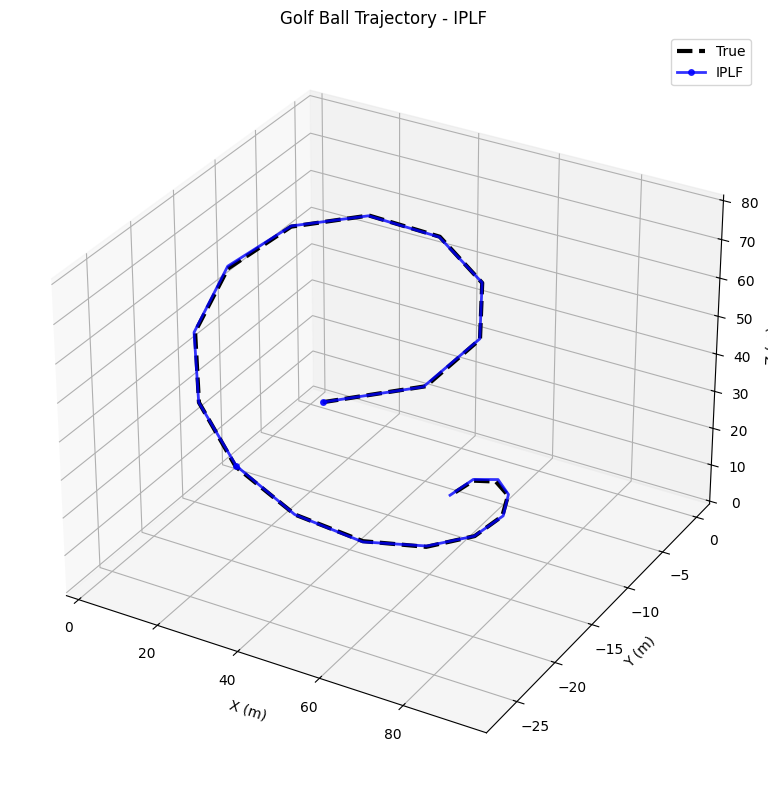

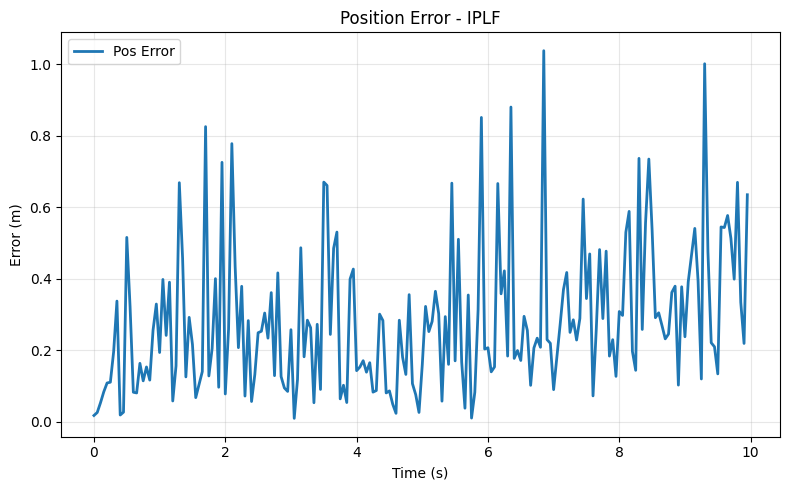

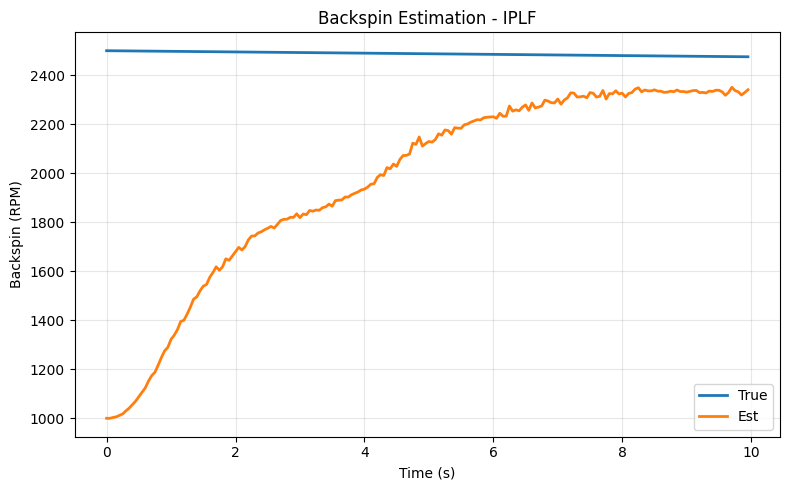

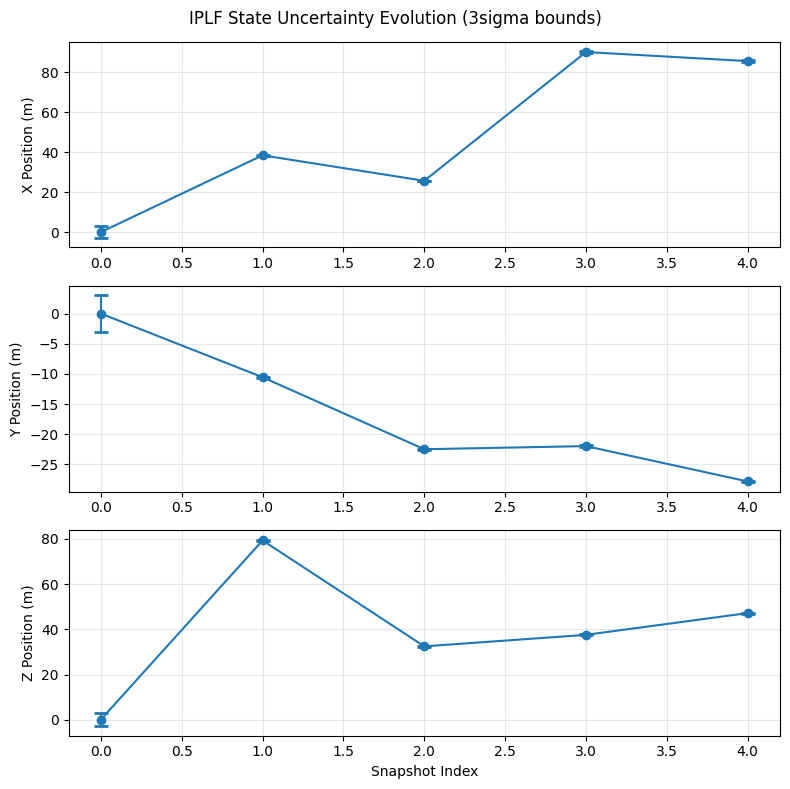

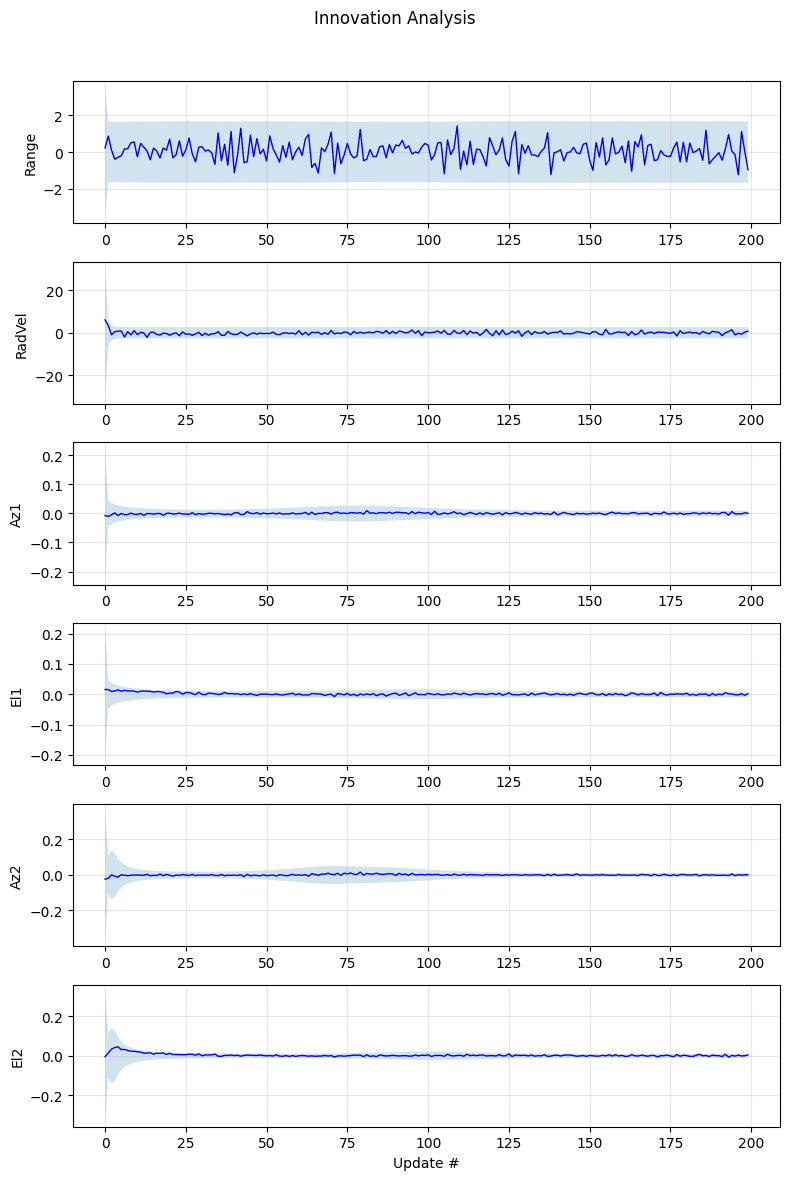

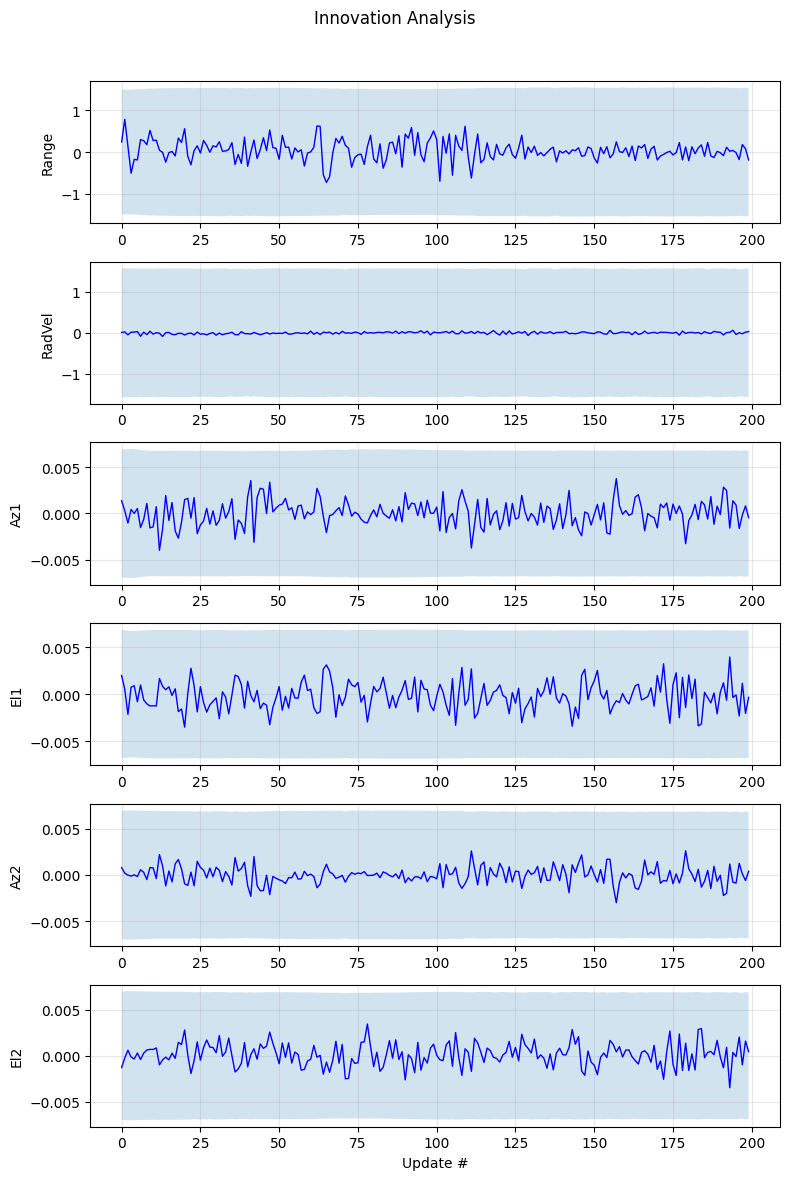

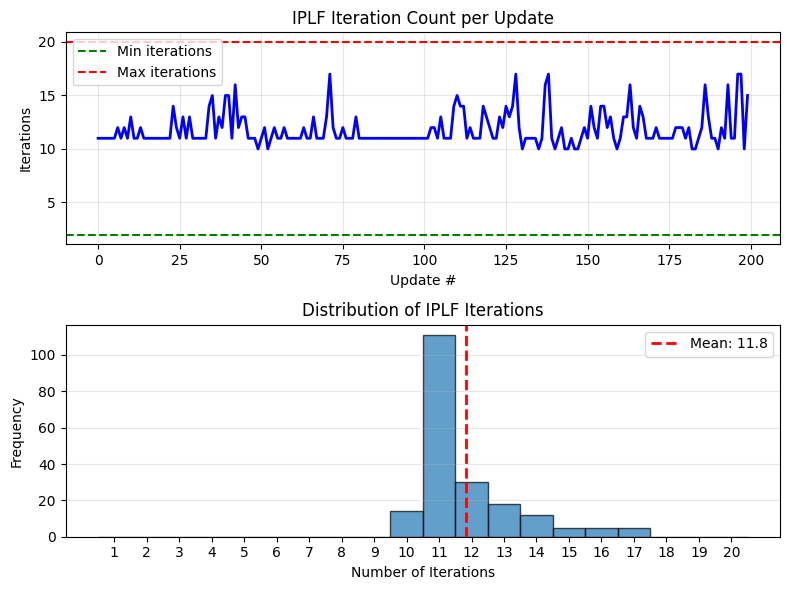

In [13]:
def main() -> None:
    """
    Main entry point for ball tracking demo.
    """
    np.random.seed(42)
    demo = BallTrackingDemo(
        physics=GolfBallPhysics(dt=0.01),
        sensors=GolfSensorSystem(),
        initial_speed=70,
        launch_angle=12,
        backspin_rpm=2500,
        sidespin_rpm=300,
        dt_meas=0.05,
    )
    demo.run()


if __name__ == "__main__":
    main()

# Version 2

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional, List, Tuple, Dict


class IPLF_Cubature:
    """
    Iterated Posterior Linearization Filter with Cubature Transform.

    This filter iteratively linearizes the measurement function with respect
    to the current best posterior approximation using Statistical Linear
    Regression (SLR) via cubature points.

    Key equations:
      SLR of h(x) w.r.t. N(x; mu, P):
        A = Psi^T @ P^(-1)
        b = z_bar - A @ mu
        Omega = Phi - A @ P @ A^T

      Where:
        z_bar = E[h(x)]
        Psi = E[(x - mu)(h(x) - z_bar)^T]
        Phi = E[(h(x) - z_bar)(h(x) - z_bar)^T]

      Posterior update:
        K = P @ A^T @ (A @ P @ A^T + Omega + R)^(-1)
        x_new = x_prior + K @ (z - A @ x_prior - b)
        P_new = P_prior - K @ (A @ P @ A^T + Omega + R) @ K^T
    """

    def __init__(
        self,
        f: Callable[[np.ndarray], np.ndarray],
        h: Callable[[np.ndarray], np.ndarray],
        Q: np.ndarray,
        R: np.ndarray,
        x0: np.ndarray,
        P0: np.ndarray,
        state_constraints: Optional[Callable[[np.ndarray], np.ndarray]] = None,
        zero_cross_covariance: bool = True,
        max_iterations: int = 5,
        convergence_threshold: float = 1e-4,
        min_iterations: int = 2,
        use_5th_order: bool = False,
    ):
        """
        Initialize IPLF with cubature-based sigma points.

        f: state transition function x_{k+1} = f(x_k)
        h: measurement function z_k = h(x_k)
        Q: process noise covariance
        R: measurement noise covariance
        x0: initial state mean
        P0: initial state covariance
        state_constraints: optional state constraints function
        zero_cross_covariance: optional zero-ing of cross-covariances
        max_iterations: maximum IPLF iterations per update
        convergence_threshold: KL divergence threshold for convergence
        min_iterations: minimum iterations to perform
        use_5th_order: If True, use 5th-order cubature rule (more sigma points)
        """
        # Check dimensions of Q and P0 match state dimension
        assert Q.shape == (len(x0), len(x0)), "Q dimension mismatch"
        assert P0.shape == (len(x0), len(x0)), "P0 dimension mismatch"

        self.f = f
        self.h = h
        self.Q = Q.copy()
        self.R = R.copy()
        self.state_constraints = state_constraints
        self.zero_cross_covariance = zero_cross_covariance

        self.x = x0.copy()
        self.P = P0.copy()

        # State dimension
        self.n = len(x0)
        self.use_5th_order = use_5th_order

        # IPLF-specific parameters
        self.max_iterations = max_iterations
        self.convergence_threshold = convergence_threshold
        self.min_iterations = min_iterations

        # Initialize cubature parameters
        self._initialize_cubature_parameters()

        # Initialize histories for diagnostics
        self.state_history: List[np.ndarray] = [self.x.copy()]
        self.cov_history: List[np.ndarray] = [self.P.copy()]
        self.innovations: List[np.ndarray] = []
        self.innovation_covariances: List[np.ndarray] = []
        self._innovations_filt: List[np.ndarray] = []
        self._innov_cov_filt: List[np.ndarray] = []
        self.iteration_counts: List[int] = []

    def _initialize_cubature_parameters(self):
        """
        Initialize cubature rule parameters based on order selection.
        """
        if self.use_5th_order:
            self._init_5th_order_cubature()
        else:
            self._init_3rd_order_cubature()

    def _init_3rd_order_cubature(self):
        """
        Initialize 3rd-order spherical-radial cubature rule.

        Number of sigma points: 2n
        """
        self.m = 2 * self.n  # Number of sigma points

        # Weights are uniform for 3rd-order cubature
        self.Wm = np.ones(self.m) / self.m
        self.Wc = np.ones(self.m) / self.m

        # Cubature point scalar
        self.xi = np.sqrt(self.n)

    def _init_5th_order_cubature(self):
        """
        Initialize 5th-order spherical-radial cubature rule.

        Number of sigma points: (2 * n^2) + 1
        """
        self.m = 2 * self.n**2 + 1

        # 5th-order weights
        w0 = 2 / (self.n + 2)
        w1 = (4 - self.n) / (2 * (self.n + 2)**2)
        w2 = 1 / ((self.n + 2)**2)

        # Initialize weight vectors
        self.Wm = np.zeros(self.m)
        self.Wc = np.zeros(self.m)

        # Central point weight
        self.Wm[0] = w0
        self.Wc[0] = w0

        # Fully symmetric set weights
        idx = 1
        # Level 1 points (2n points)
        for i in range(2 * self.n):
            self.Wm[idx] = w1
            self.Wc[idx] = w1
            idx += 1

        # Level 2 points (2n*(n-1) points)
        remaining_points = self.m - idx
        for i in range(remaining_points):
            self.Wm[idx] = w2
            self.Wc[idx] = w2
            idx += 1

    def _compute_sigma_points(
        self,
        x: np.ndarray,
        P: np.ndarray
    ) -> np.ndarray:
        """
        Compute cubature sigma points for given mean x and covariance P.
        """
        n = len(x)

        # Regularize covariance for numerical stability
        P_reg = P + 1e-9 * np.eye(n)

        # Compute matrix square root using Cholesky or eigendecomposition
        try:
            S = np.linalg.cholesky(P_reg)
        except np.linalg.LinAlgError:
            eigvals, eigvecs = np.linalg.eigh(P_reg)
            eigvals = np.maximum(eigvals, 1e-9)
            S = eigvecs @ np.diag(np.sqrt(eigvals)) @ eigvecs.T

        if self.use_5th_order:
            return self._compute_5th_order_sigma_points(x, S)
        else:
            return self._compute_3rd_order_sigma_points(x, S)

    def _compute_3rd_order_sigma_points(
        self,
        x: np.ndarray,
        S: np.ndarray
    ) -> np.ndarray:
        """
        Compute 3rd-order cubature sigma points.

        The cubature points are located at +/- sqrt(n) along each coordinate axis.
        """
        n = self.n
        sigma_points = np.zeros((self.m, n))

        # Generate cubature points
        idx = 0
        for i in range(n):
            # Positive direction
            sigma_points[idx] = x + self.xi * S[:, i]
            idx += 1
            # Negative direction
            sigma_points[idx] = x - self.xi * S[:, i]
            idx += 1

        return sigma_points

    def _compute_5th_order_sigma_points(
        self,
        x: np.ndarray,
        S: np.ndarray
    ) -> np.ndarray:
        """
        Compute 5th-order cubature sigma points.

        Includes central point and two levels of symmetric points.
        """
        n = self.n
        sigma_points = np.zeros((self.m, n))

        # Scaling factors
        s1 = np.sqrt(n + 2)
        s2 = np.sqrt((n + 2) / 2)

        idx = 0

        # Central point
        sigma_points[idx] = x
        idx += 1

        # Level 1: Fully symmetric set along axes
        for i in range(n):
            sigma_points[idx] = x + s1 * S[:, i]
            idx += 1
            sigma_points[idx] = x - s1 * S[:, i]
            idx += 1

        # Level 2: Fully symmetric set on 2D subspaces
        for i in range(n):
            for j in range(i + 1, n):
                # Four points on the (i,j) plane
                sigma_points[idx] = x + s2 * (S[:, i] + S[:, j])
                idx += 1
                sigma_points[idx] = x + s2 * (S[:, i] - S[:, j])
                idx += 1
                sigma_points[idx] = x - s2 * (S[:, i] - S[:, j])
                idx += 1
                sigma_points[idx] = x - s2 * (S[:, i] + S[:, j])
                idx += 1

        return sigma_points

    def _statistical_linear_regression(
        self,
        x_mean: np.ndarray,
        P_cov: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Perform Statistical Linear Regression of h w.r.t. N(x_mean, P_cov).

        Returns:
            A: Linear approximation matrix (nz x nx)
            b: Offset vector (nz x 1)
            Omega: Approximation error covariance (nz x nz)
        """
        # Generate sigma points using cubature rule
        sigma_points = self._compute_sigma_points(x_mean, P_cov)
        m = sigma_points.shape[0]

        # Propagate through measurement function
        Z = np.vstack([self.h(sigma_points[i]) for i in range(m)])
        nz = Z.shape[1]

        # Compute moments
        z_bar = np.sum(self.Wm[:, None] * Z, axis=0)

        # Cross-covariance Psi
        Psi = np.zeros((self.n, nz))
        for i in range(m):
            dx = sigma_points[i] - x_mean
            dz = Z[i] - z_bar
            Psi += self.Wc[i] * np.outer(dx, dz)

        # Auto-covariance Phi
        Phi = np.zeros((nz, nz))
        for i in range(m):
            dz = Z[i] - z_bar
            Phi += self.Wc[i] * np.outer(dz, dz)

        # Compute SLR parameters
        try:
            P_inv = np.linalg.inv(P_cov + 1e-9 * np.eye(self.n))
        except np.linalg.LinAlgError:
            P_inv = np.linalg.pinv(P_cov + 1e-9 * np.eye(self.n))

        A = Psi.T @ P_inv
        b = z_bar - A @ x_mean
        Omega = Phi - A @ P_cov @ A.T

        # Ensure Omega is positive semi-definite
        Omega = self._ensure_positive_definite(Omega)

        return A, b, Omega

    def _ensure_positive_definite(self, M: np.ndarray, epsilon: float = 1e-6) -> np.ndarray:
        """
        Ensure matrix is positive definite for numerical stability.
        """
        # Symmetrize
        M = 0.5 * (M + M.T)

        # Eigendecomposition
        eigvals, eigvecs = np.linalg.eigh(M)

        # Ensure all eigenvalues are positive
        eigvals = np.maximum(eigvals, epsilon)

        # Reconstruct
        return eigvecs @ np.diag(eigvals) @ eigvecs.T

    def _compute_posterior(
        self,
        x_prior: np.ndarray,
        P_prior: np.ndarray,
        z: np.ndarray,
        A: np.ndarray,
        b: np.ndarray,
        Omega: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Compute posterior using linearized measurement model.
        """
        # Innovation covariance
        S = A @ P_prior @ A.T + Omega + self.R
        S = self._ensure_positive_definite(S)

        # Kalman gain
        try:
            K = P_prior @ A.T @ np.linalg.inv(S)
        except np.linalg.LinAlgError:
            K = P_prior @ A.T @ np.linalg.pinv(S)

        # Innovation
        y = z - (A @ x_prior + b)

        # Posterior mean
        x_post = x_prior + K @ y

        # Posterior covariance using Joseph form for stability
        I_KA = np.eye(self.n) - K @ A
        P_post = I_KA @ P_prior @ I_KA.T + K @ (Omega + self.R) @ K.T

        # Ensure positive definiteness
        P_post = self._ensure_positive_definite(P_post)

        return x_post, P_post

    def _check_convergence(
        self,
        x_old: np.ndarray,
        P_old: np.ndarray,
        x_new: np.ndarray,
        P_new: np.ndarray
    ) -> bool:
        """
        Check convergence using KL divergence between successive approximations.
        """
        dx = x_new - x_old

        # Check if means are very close
        if np.linalg.norm(dx) < 1e-10:
            return True

        # Check if covariances are very similar
        if np.linalg.norm(P_new - P_old, 'fro') < 1e-10:
            return True

        try:
            # KL divergence for Gaussians: D(N_old || N_new)
            P_new_reg = P_new + 1e-9 * np.eye(self.n)
            P_old_reg = P_old + 1e-9 * np.eye(self.n)

            P_new_inv = np.linalg.inv(P_new_reg)

            # Compute log determinant ratio safely
            sign_new, logdet_new = np.linalg.slogdet(P_new_reg)
            sign_old, logdet_old = np.linalg.slogdet(P_old_reg)

            if sign_new <= 0 or sign_old <= 0:
                # Fallback to norm-based criterion
                return (np.linalg.norm(dx) < self.convergence_threshold and
                        np.linalg.norm(P_new - P_old, 'fro') < self.convergence_threshold)

            log_det_ratio = logdet_new - logdet_old

            kl_div = 0.5 * (
                np.trace(P_new_inv @ P_old) - self.n +
                dx.T @ P_new_inv @ dx +
                log_det_ratio
            )

            return float(kl_div) < self.convergence_threshold

        except (np.linalg.LinAlgError, ValueError):
            # Fallback: use norm-based criterion
            return (np.linalg.norm(dx) < self.convergence_threshold and
                    np.linalg.norm(P_new - P_old, 'fro') < self.convergence_threshold)

    def predict(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Perform prediction step using cubature-point propagation.
        """
        # Generate cubature sigma points from current state
        sigma_points = self._compute_sigma_points(self.x, self.P)
        m = sigma_points.shape[0]

        # Propagate through state transition
        X_pred = np.vstack([self.f(sigma_points[i]) for i in range(m)])

        # Compute predicted mean
        x_pred = np.sum(self.Wm[:, None] * X_pred, axis=0)

        # Compute predicted covariance
        P_pred = self.Q.copy()
        for i in range(m):
            dx = X_pred[i] - x_pred
            P_pred += self.Wc[i] * np.outer(dx, dx)

        # Apply constraints to predicted mean if needed
        if self.state_constraints:
            x_old = x_pred.copy()
            x_pred = self.state_constraints(x_pred)

            # Inflate covariance for clipped dimensions
            clipped = x_pred != x_old
            for i, was_clipped in enumerate(clipped):
                if was_clipped:
                    diff = x_old[i] - x_pred[i]
                    P_pred[i, i] += diff * diff

                    if self.zero_cross_covariance:
                        var_i = P_pred[i, i]
                        P_pred[i, :] = 0.0
                        P_pred[:, i] = 0.0
                        P_pred[i, i] = var_i

        # Update state
        self.x = x_pred
        self.P = P_pred
        return self.x.copy(), self.P.copy()

    def update(self, z: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Perform IPLF measurement update with iterations.
        """
        x_prior = self.x.copy()
        P_prior = self.P.copy()

        # Initialize with prior for iterations
        x_current = x_prior
        P_current = P_prior

        # Store initial innovation for diagnostics
        A_init, b_init, Omega_init = self._statistical_linear_regression(x_prior, P_prior)
        z_pred_init = A_init @ x_prior + b_init
        S_init = A_init @ P_prior @ A_init.T + Omega_init + self.R
        self.innovations.append(z - z_pred_init)
        self.innovation_covariances.append(S_init)

        # IPLF iterations
        for i in range(self.max_iterations):
            # Perform SLR w.r.t. current posterior approximation
            A, b, Omega = self._statistical_linear_regression(x_current, P_current)

            # Compute new posterior using current iterate
            x_new, P_new = self._compute_posterior(x_current, P_current, z, A, b, Omega)

            # Check convergence after minimum iterations
            if i >= self.min_iterations - 1:
                if self._check_convergence(x_current, P_current, x_new, P_new):
                    self.iteration_counts.append(i + 1)
                    break

            # Update for next iteration
            x_current = x_new
            P_current = P_new
        else:
            # Max iterations reached
            self.iteration_counts.append(self.max_iterations)

        # Apply constraints to final posterior mean if needed
        if self.state_constraints:
            x_old = x_new.copy()
            x_new = self.state_constraints(x_new)

            # Inflate covariance for clipped dimensions
            clipped = x_new != x_old
            for i, was_clipped in enumerate(clipped):
                if was_clipped:
                    diff = x_old[i] - x_new[i]
                    P_new[i, i] += diff * diff

                    if self.zero_cross_covariance:
                        var_i = P_new[i, i]
                        P_new[i, :] = 0.0
                        P_new[:, i] = 0.0
                        P_new[i, i] = var_i

        # Ensure final positive definiteness
        P_new = self._ensure_positive_definite(P_new)

        # Update state
        self.x = x_new
        self.P = P_new

        # Store histories
        self.state_history.append(self.x.copy())
        self.cov_history.append(self.P.copy())

        # Compute filtered innovation for diagnostics
        A_filt, b_filt, Omega_filt = self._statistical_linear_regression(self.x, self.P)
        z_filt = A_filt @ self.x + b_filt
        S_filt = A_filt @ self.P @ A_filt.T + Omega_filt + self.R
        self._innovations_filt.append(z - z_filt)
        self._innov_cov_filt.append(S_filt)

        return self.x.copy(), self.P.copy()

    def run_sequence(
        self,
        measurements: np.ndarray,
        steps_per_meas: int
    ) -> np.ndarray:
        """
        Run IPLF over a sequence of measurements.

        For each measurement z_k:
          - Call predict() steps_per_meas times
          - Call update(z_k)
        Returns array of state_history excluding initial state.
        """
        for z in measurements:
            for _ in range(steps_per_meas):
                self.predict()
            self.update(z)
        return np.array(self.state_history)[1:]

    def get_nis(self, method: str = 'predicted') -> Optional[float]:
        """
        Compute average Normalized Innovation Squared (NIS).

        method: 'predicted' uses pre-update innovations,
                'filtered' uses post-update innovations.
        """
        if method == 'predicted':
            inn_list = self.innovations
            S_list = self.innovation_covariances
        elif method == 'filtered':
            inn_list = self._innovations_filt
            S_list = self._innov_cov_filt
        else:
            raise ValueError("method must be 'predicted' or 'filtered'")

        if not inn_list:
            return None

        nis_vals = []
        for inn, S in zip(inn_list, S_list):
            try:
                # NIS = innov^T S^{-1} innov
                nis = float(inn.T @ np.linalg.inv(S) @ inn)
                nis_vals.append(nis)
            except np.linalg.LinAlgError:
                continue

        return float(np.mean(nis_vals)) if nis_vals else None

In [15]:
class GolfBallPhysics:
    """
    Golf ball physics: quadratic drag plus Magnus effect plus spin decay.

    State x = [pos(3), vel(3), spin(3)]
    Equations:
      Fd = -0.5 * rho * Cd * A * |v| * v
      Fm =  0.5 * rho * Cl * A * cross(spin, v)
      a = (Fd + Fm) / m - [0,0,g]
      pos' = pos + dt * v
      vel' = vel + dt * a
      spin' = spin * (1 - decay_factor*dt)
    """

    def __init__(self, dt: float = 0.01):
        """
        Initialize physics parameters.
        dt: time step size
        """
        self.dt = dt
        self.m = 0.04593
        self.r = 0.02135
        self.A = np.pi * self.r**2
        self.g = 9.81
        self.rho = 1.225
        self.Cd = 0.25
        self.Cl = 0.2

    def state_transition(self, x: np.ndarray) -> np.ndarray:
        """
        Compute next state given current state x.
        """
        pos = x[0:3]
        vel = x[3:6]
        spin = x[6:9]

        # Compute drag: Fd = -0.5*rho*Cd*A*|v|*v
        v_mag = max(np.linalg.norm(vel), 1e-10)
        Fd = -0.5 * self.rho * self.Cd * self.A * v_mag * vel

        # Compute Magnus: Fm = 0.5*rho*Cl*A*cross(spin, vel)
        Fm = 0.5 * self.rho * self.Cl * self.A * np.cross(spin, vel)

        # Compute acceleration and apply gravity
        a = (Fd + Fm) / self.m
        a[2] -= self.g

        # Integrate position and velocity
        new_pos = pos + self.dt * vel
        new_vel = vel + self.dt * a

        # Apply spin decay
        new_spin = spin * (1.0 - 0.001 * self.dt)

        return np.hstack([new_pos, new_vel, new_spin])

In [16]:
class GolfSensorSystem:
    """
    Sensor system fusing radar and two cameras.

    Radar: [range, radial velocity]
    Camera: [azimuth, elevation] angles.
    """

    def __init__(
        self,
        radar_pos: Optional[np.ndarray] = None,
        camera_positions: Optional[List[np.ndarray]] = None,
    ):
        """
        Initialize sensor positions and noise std deviations.
        """
        # Set radar position
        self.radar_pos = (
            radar_pos
            if radar_pos is not None
            else np.array([0.0, -5.0, 2.0])
        )
        # Set camera positions
        self.camera_positions = (
            camera_positions
            if camera_positions is not None
            else [
                np.array([-10.0, -5.0, 5.0]),
                np.array([10.0, -5.0, 5.0]),
            ]
        )
        self.radar_range_std = 0.5
        self.radar_velocity_std = 0.5
        self.camera_angle_std = 0.002

    def radar_measurement(
        self,
        x: np.ndarray,
        add_noise: bool = True
    ) -> np.ndarray:
        """
        Compute radar measurement [range, radial velocity].
        """
        pos = x[0:3]
        vel = x[3:6]
        r_vec = pos - self.radar_pos
        r_mag = max(np.linalg.norm(r_vec), 1e-10)
        r_hat = r_vec / r_mag
        v_rad = float(np.dot(vel, r_hat))

        meas = np.array([r_mag, v_rad])
        if add_noise:
            meas += np.random.normal(
                loc=[0.0, 0.0],
                scale=[self.radar_range_std,
                       self.radar_velocity_std],
            )
        return meas

    def camera_measurement(
        self,
        x: np.ndarray,
        camera_idx: int = 0,
        add_noise: bool = True
    ) -> np.ndarray:
        """
        Compute camera measurement [azimuth, elevation].
        """
        pos = x[0:3]
        cam = self.camera_positions[camera_idx]
        r = pos - cam
        r_xy2 = max(r[0]**2 + r[1]**2, 1e-10)

        # Azimuth and elevation
        az = float(np.arctan2(r[1], r[0]))
        el = float(np.arctan2(r[2], np.sqrt(r_xy2)))

        meas = np.array([az, el])
        if add_noise:
            meas += np.random.normal(
                loc=0.0,
                scale=self.camera_angle_std,
                size=2,
            )
        return meas

    def fused_measurement(
        self,
        x: np.ndarray,
        add_noise: bool = True
    ) -> np.ndarray:
        """
        Fuse radar and two camera measurements into 6D vector.
        """
        return np.hstack([
            self.radar_measurement(x, add_noise),
            self.camera_measurement(x, 0, add_noise),
            self.camera_measurement(x, 1, add_noise),
        ])

    def measurement_function(
        self,
        x: np.ndarray
    ) -> np.ndarray:
        """
        Measurement function without noise for IPLF update.
        """
        return self.fused_measurement(x, add_noise=False)

In [17]:
def golf_ball_constraints(x: np.ndarray) -> np.ndarray:
    """
    Enforce physical constraints:
      altitude >= 0,
      max velocity = 100 m/s,
      max spin = 300*2*pi rad/s.
    """
    y = x.copy()

    # Clip altitude to ground level
    y[2] = max(0.0, y[2])

    # Clip velocity magnitude
    v = y[3:6]
    v_norm = np.linalg.norm(v)
    if v_norm > 100.0:
        y[3:6] = v * 100.0 / v_norm

    # Clip spin magnitude
    if len(y) >= 9:
        spin = y[6:9]
        max_spin = 300 * 2 * np.pi
        s_norm = np.linalg.norm(spin)
        if s_norm > max_spin:
            y[6:9] = spin * max_spin / s_norm

    return y

In [18]:
def simulate_golf_shot(
    physics: GolfBallPhysics,
    sensors: GolfSensorSystem,
    initial_speed: float = 70,
    launch_angle: float = 12,
    backspin_rpm: float = 2500,
    sidespin_rpm: float = 300,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Simulate 9D state trajectory and 6D noisy measurements.

    x0 = [pos_x,pos_y,pos_z,vx,vy,vz,spin_x,spin_y,spin_z]
    """
    theta = np.deg2rad(launch_angle)
    back = backspin_rpm * 2 * np.pi / 60
    side = sidespin_rpm * 2 * np.pi / 60
    vx = initial_speed * np.cos(theta)
    vz = initial_speed * np.sin(theta)

    x0 = np.array([
        0.0, 0.0, 0.1,
        vx,  0.0, vz,
        side, -back, 0.0,
    ])
    traj: List[np.ndarray] = [x0.copy()]
    meas: List[np.ndarray] = []

    dt_meas = 0.05
    t = 0.0
    max_t = 10.0

    # Simulate until ground impact or max time
    while traj[-1][2] >= 0 and t < max_t:
        for _ in range(int(dt_meas / physics.dt)):
            traj.append(physics.state_transition(traj[-1]))
        if traj[-1][2] >= 0:
            meas.append(sensors.fused_measurement(traj[-1], add_noise=True))
        t += dt_meas

    return np.array(traj), np.array(meas)

In [19]:
def rmse(a: np.ndarray, b: np.ndarray) -> float:
    """
    Compute root mean square error between arrays a and b.
    """
    return float(np.sqrt(np.mean((a - b)**2)))


def position_rmse(truth: np.ndarray, est: np.ndarray) -> float:
    """
    Compute RMSE for position components.
    """
    return rmse(truth[:, :3], est[:, :3])


def velocity_rmse(truth: np.ndarray, est: np.ndarray) -> float:
    """
    Compute RMSE for velocity components.
    """
    return rmse(truth[:, 3:6], est[:, 3:6])


def spin_error(true_rpm: np.ndarray, est_rpm: np.ndarray) -> float:
    """
    Compute mean absolute error for spin (RPM).
    """
    return float(np.mean(np.abs(true_rpm - est_rpm)))


def landing_error(t: np.ndarray, e: np.ndarray) -> float:
    """
    Compute 2D landing error between true t and estimated e.
    """
    return float(np.linalg.norm(t[:2] - e[:2]))

In [20]:
def plot_trajectory(
    true_traj: np.ndarray,
    est_trajs: List[np.ndarray],
    labels: List[str],
    sample: int = 5,
    title: Optional[str] = None,
    ) -> None:
    """
    Plot 3D trajectory of true and estimated states.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    idx = slice(0, None, sample)

    ax.plot(
        true_traj[idx, 0],
        true_traj[idx, 1],
        true_traj[idx, 2],
        '--k',
        lw=3,
        label=labels[0]
    )
    colors = ['b', 'r', 'g', 'm', 'c']

    for i, (traj, lbl) in enumerate(zip(est_trajs, labels[1:])):
        ax.plot(
            traj[idx, 0],
            traj[idx, 1],
            traj[idx, 2],
            '-',
            color=colors[i],
            lw=2,
            marker='o',
            markevery=10,
            markersize=4,
            alpha=0.8,
            label=lbl
        )

    ax.set(xlabel='X (m)', ylabel='Y (m)', zlabel='Z (m)')
    if title:
        ax.set_title(title)
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [21]:
def plot_error(
    t: np.ndarray,
    errors: List[np.ndarray],
    labels: List[str],
    ylabel: str,
    title: Optional[str] = None,
    logscale: bool = False,
    ) -> None:
    """
    Plot error metrics over time.
    """
    plt.figure(figsize=(8, 5))
    for err, lbl in zip(errors, labels):
        if logscale:
            plt.semilogy(t, err, lw=2, label=lbl)
        else:
            plt.plot(t, err, lw=2, label=lbl)
    plt.xlabel('Time (s)')
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [22]:
def plot_sigma_points_analysis(
    filter_: IPLF_Cubature,
    n_snapshots: int = 5
    ) -> None:
    """
    Plot sigma point spread analysis for IPLF state dims 0,1,2.
    """
    indices = np.linspace(
        0,
        len(filter_.state_history) - 1,
        n_snapshots,
        dtype=int
    )

    fig, axes = plt.subplots(3, 1, figsize=(8, 8))
    labels = ['X', 'Y', 'Z']

    for ax, label, idx in zip(axes, labels, range(3)):
        positions = [filter_.state_history[i][idx] for i in indices]
        stds = []
        for i in indices:
            var = filter_.cov_history[i][idx, idx]
            stds.append(np.sqrt(max(var, 0)))
        ax.errorbar(
            range(n_snapshots),
            positions,
            yerr=3 * np.array(stds),
            fmt='o-',
            capsize=5,
            capthick=2
        )
        ax.set_ylabel(f'{label} Position (m)')
        ax.grid(alpha=0.3)

    axes[-1].set_xlabel('Snapshot Index')
    fig.suptitle('IPLF-Cubature State Uncertainty Evolution (3sigma bounds)')
    plt.tight_layout()
    plt.show()

In [23]:
def plot_innovation_analysis(
    innovations: List[np.ndarray],
    covariances: List[np.ndarray],
    ) -> None:
    """
    Plot innovation values with 3sigma covariance bounds.
    """
    inn = np.vstack(innovations)
    n_meas = inn.shape[1]
    fig, axes = plt.subplots(n_meas, 1, figsize=(8, 2 * n_meas))
    if n_meas == 1:
        axes = [axes]

    names = ['Range', 'RadVel', 'Az1', 'El1', 'Az2', 'El2']

    for i, ax in enumerate(axes):
        ax.plot(inn[:, i], '-b', lw=1)
        sigma3 = 3 * np.sqrt([C[i, i] for C in covariances])
        ax.fill_between(range(len(inn)), -sigma3, sigma3, alpha=0.2)
        ax.set_ylabel(names[i])
        ax.grid(alpha=0.3)

    axes[-1].set_xlabel('Update #')
    fig.suptitle('Innovation Analysis')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [24]:
def plot_iteration_analysis(filter_: IPLF_Cubature) -> None:
    """
    Plot IPLF iteration count analysis.
    """
    if not filter_.iteration_counts:
        return

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

    # Iteration counts over time
    ax1.plot(filter_.iteration_counts, 'b-', lw=2)
    ax1.axhline(y=filter_.min_iterations, color='g', linestyle='--', label='Min iterations')
    ax1.axhline(y=filter_.max_iterations, color='r', linestyle='--', label='Max iterations')
    ax1.set_ylabel('Iterations')
    ax1.set_xlabel('Update #')
    ax1.set_title('IPLF-Cubature Iteration Count per Update')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Histogram of iteration counts
    bins = np.arange(0.5, filter_.max_iterations + 1.5, 1)
    ax2.hist(filter_.iteration_counts, bins=bins,
            edgecolor='black', alpha=0.7, align='mid')
    ax2.set_xlabel('Number of Iterations')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of IPLF-Cubature Iterations')
    ax2.set_xticks(range(1, filter_.max_iterations + 1))
    ax2.grid(alpha=0.3, axis='y')

    # Add statistics
    mean_iter = np.mean(filter_.iteration_counts)
    ax2.axvline(x=mean_iter, color='r', linestyle='--', lw=2,
                label=f'Mean: {mean_iter:.1f}')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [25]:
def plot_cubature_points(filter_: IPLF_Cubature, state_idx: int = 0) -> None:
    """
    Visualize cubature point locations for a given state.
    """
    # Get current state and covariance
    x = filter_.state_history[state_idx]
    P = filter_.cov_history[state_idx]

    # Generate cubature points
    sigma_points = filter_._compute_sigma_points(x, P)

    # Plot first 3 dimensions
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot center point
    ax.scatter(x[0], x[1], x[2], c='r', s=200, marker='*', label='Mean')

    # Plot cubature points
    ax.scatter(sigma_points[:, 0], sigma_points[:, 1], sigma_points[:, 2],
                c='b', s=100, alpha=0.6, label='Cubature Points')

    # Draw lines from center to cubature points
    for i in range(sigma_points.shape[0]):
        ax.plot([x[0], sigma_points[i, 0]],
                [x[1], sigma_points[i, 1]],
                [x[2], sigma_points[i, 2]],
                'k-', alpha=0.2)

    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title(f'Cubature Points Distribution ({"5th" if filter_.use_5th_order else "3rd"} order)')
    ax.legend()
    plt.tight_layout()
    plt.show()

In [26]:
class BallTrackingDemo:
    """
    Orchestrates simulation, IPLF-Cubature filtering, metrics, and plotting
    for a golf ball ballistic tracking demo.
    """

    def __init__(
        self,
        physics: GolfBallPhysics,
        sensors: GolfSensorSystem,
        initial_speed: float = 70,
        launch_angle: float = 12,
        backspin_rpm: float = 2500,
        sidespin_rpm: float = 300,
        dt_meas: float = 0.05,
        use_5th_order: bool = False,
    ):
        """
        Initialize demo parameters.
        """
        self.physics = physics
        self.sensors = sensors
        self.initial_speed = initial_speed
        self.launch_angle = launch_angle
        self.backspin_rpm = backspin_rpm
        self.sidespin_rpm = sidespin_rpm
        self.dt_meas = dt_meas
        self.use_5th_order = use_5th_order

    def run(self) -> None:
        """
        Run simulation, filtering, compute metrics, and plotting.
        """
        # Simulate trajectory and measurements
        traj, meas = simulate_golf_shot(
            self.physics,
            self.sensors,
            self.initial_speed,
            self.launch_angle,
            self.backspin_rpm,
            self.sidespin_rpm,
        )
        print(f"Simulated {len(traj)} states, {len(meas)} measurements")

        # Initialize filter with guessed initial state and covariances
        x0_true = traj[0]
        x0_guess = x0_true.copy()
        x0_guess[3:6] *= 0.9
        x0_guess[6:9] = [0, -1000 * 2 * np.pi / 60, 0]

        P0 = np.diag([1.0] * 3 + [10] * 3 + [50] * 3)
        Q = np.diag([0.01] * 3 + [0.1] * 3 + [1.0] * 3)
        R = np.diag([
            self.sensors.radar_range_std**2,
            self.sensors.radar_velocity_std**2,
            *(
                self.sensors.camera_angle_std**2
                for _ in range(4)
            ),
        ])

        # Create IPLF-Cubature instance
        filter_ = IPLF_Cubature(
            f=self.physics.state_transition,
            h=self.sensors.measurement_function,
            Q=Q,
            R=R,
            x0=x0_guess,
            P0=P0,
            state_constraints=golf_ball_constraints,
            max_iterations=20,
            convergence_threshold=1e-2,
            min_iterations=2,
            use_5th_order=self.use_5th_order,
        )

        # Compute steps per measurement
        steps = int(self.dt_meas / self.physics.dt)

        # Run filter sequence
        est_states = filter_.run_sequence(meas, steps)

        # Align truth and estimates
        truth_meas = traj[steps::steps]
        n = min(len(truth_meas), len(est_states))
        truth = truth_meas[:n]
        est = est_states[:n]
        time = np.arange(n) * self.dt_meas

        # Compute performance metrics
        pos_err = position_rmse(truth, est)
        vel_err = velocity_rmse(truth, est)
        true_spin = -truth[:, 7] * 60 / (2 * np.pi)
        est_spin = -est[:, 7] * 60 / (2 * np.pi)
        spin_err_val = spin_error(true_spin, est_spin)

        t_idx = np.where(truth[:, 2] <= 0)[0]
        e_idx = np.where(est[:, 2] <= 0)[0]
        land_err = (
            landing_error(truth[t_idx[0]], est[e_idx[0]])
            if t_idx.size and e_idx.size else None
        )

        nis_pred = filter_.get_nis('predicted')
        nis_filt = filter_.get_nis('filtered')

        # Print performance metrics
        print("\n=== Performance Metrics ===")
        print(f"Filter Type    : IPLF-Cubature ({'5th' if self.use_5th_order else '3rd'} order)")
        print(f"Sigma Points   : {filter_.m} per update")
        print(f"Position RMSE  : {pos_err:.3f} m")
        print(f"Velocity RMSE  : {vel_err:.3f} m/s")
        print(f"Backspin MAE   : {spin_err_val:.0f} RPM")
        if land_err is not None:
            print(f"Landing Error  : {land_err:.2f} m")
        print(f"IPLF Iterations: min={filter_.min_iterations}, "
                f"max={filter_.max_iterations}, "
                f"threshold={filter_.convergence_threshold}")
        if filter_.iteration_counts:
            print(f"Avg iterations : {np.mean(filter_.iteration_counts):.1f}")
        if nis_pred is not None:
            print(f"NIS (predicted): {nis_pred:.2f}")
        if nis_filt is not None:
            print(f"NIS (filtered) : {nis_filt:.2f}\n")

        # Generate plots
        plot_trajectory(
            truth,
            [est],
            ['True', 'IPLF-Cubature'],
            sample=10,
            title=f'Golf Ball Trajectory - IPLF-Cubature ({"5th" if self.use_5th_order else "3rd"} order)',
        )
        plot_error(
            time,
            [np.linalg.norm(truth[:, :3] - est[:, :3], axis=1)],
            ['Pos Error'],
            ylabel='Error (m)',
            title='Position Error - IPLF-Cubature'
        )
        plot_error(
            time,
            [true_spin, est_spin],
            ['True', 'Est'],
            ylabel='Backspin (RPM)',
            title='Backspin Estimation - IPLF-Cubature'
        )
        plot_sigma_points_analysis(filter_)
        plot_innovation_analysis(
            filter_.innovations,
            filter_.innovation_covariances,
        )
        plot_innovation_analysis(
            filter_._innovations_filt,
            filter_._innov_cov_filt,
        )
        plot_iteration_analysis(filter_)
        plot_cubature_points(filter_, state_idx=len(filter_.state_history)//2)

In [27]:
def main(use_5th_order: bool = False) -> None:
    """
    Main entry point for ball tracking demo with IPLF.
    """
    np.random.seed(42)
    demo = BallTrackingDemo(
        physics=GolfBallPhysics(dt=0.01),
        sensors=GolfSensorSystem(),
        initial_speed=70,
        launch_angle=12,
        backspin_rpm=2500,
        sidespin_rpm=300,
        dt_meas=0.05,
        use_5th_order=use_5th_order,
    )
    demo.run()

Simulated 1001 states, 200 measurements

=== Performance Metrics ===
Filter Type    : IPLF-Cubature (3rd order)
Sigma Points   : 18 per update
Position RMSE  : 0.200 m
Velocity RMSE  : 1.743 m/s
Backspin MAE   : 515 RPM
IPLF Iterations: min=2, max=20, threshold=0.01
Avg iterations : 11.8
NIS (predicted): 4.19
NIS (filtered) : 1.56



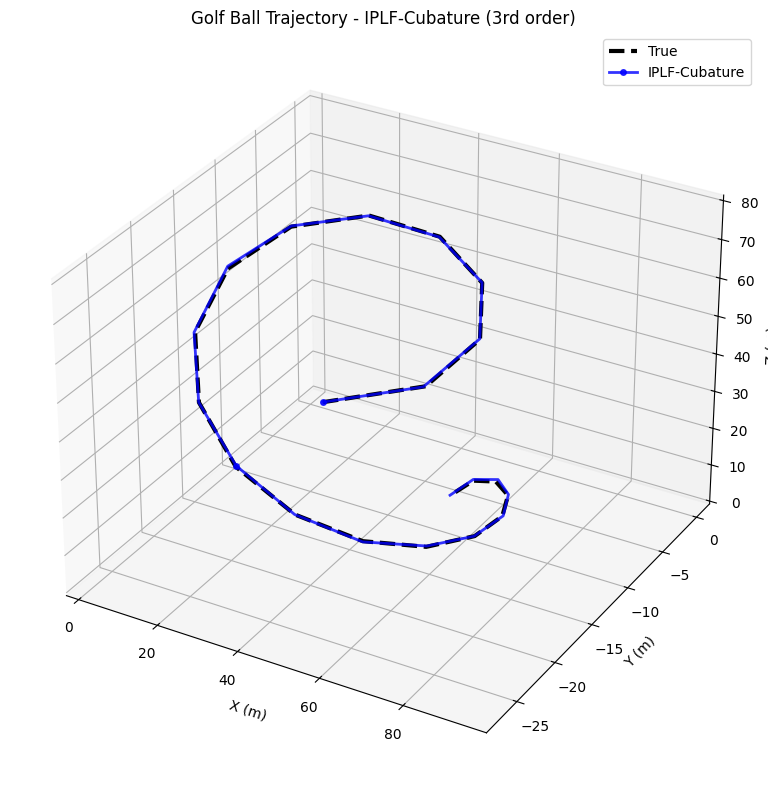

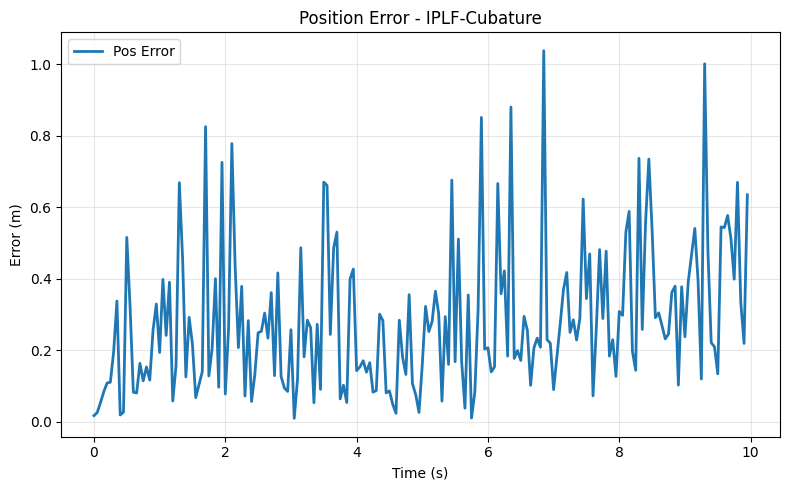

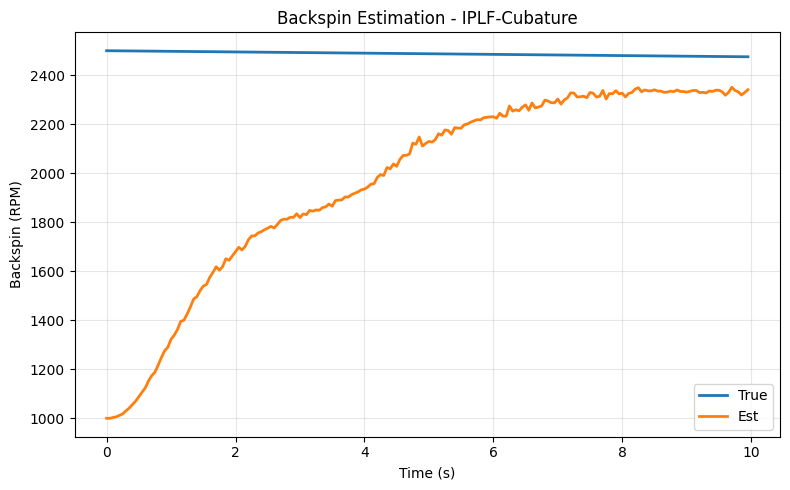

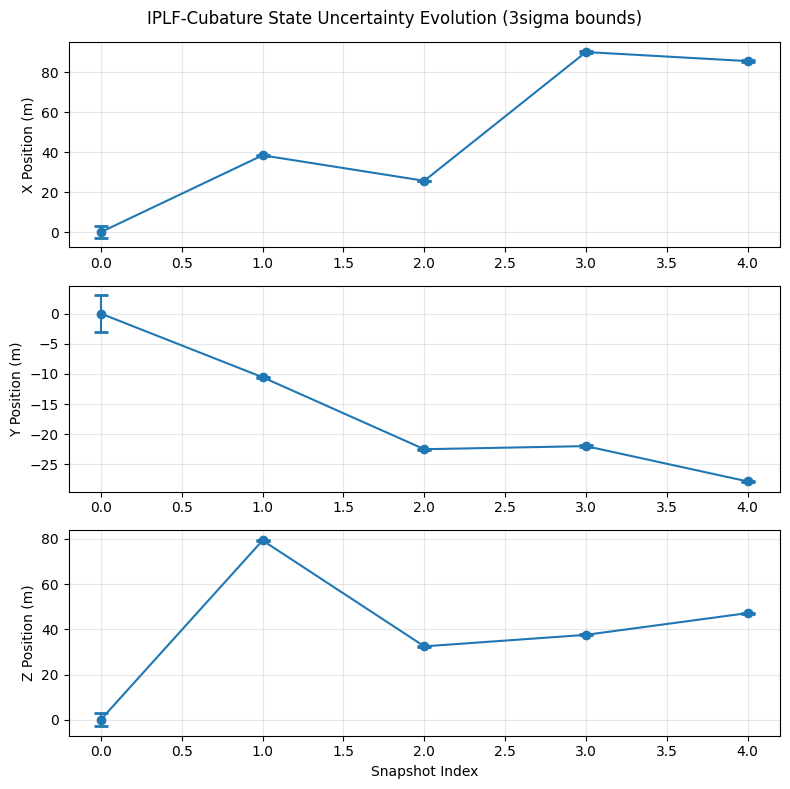

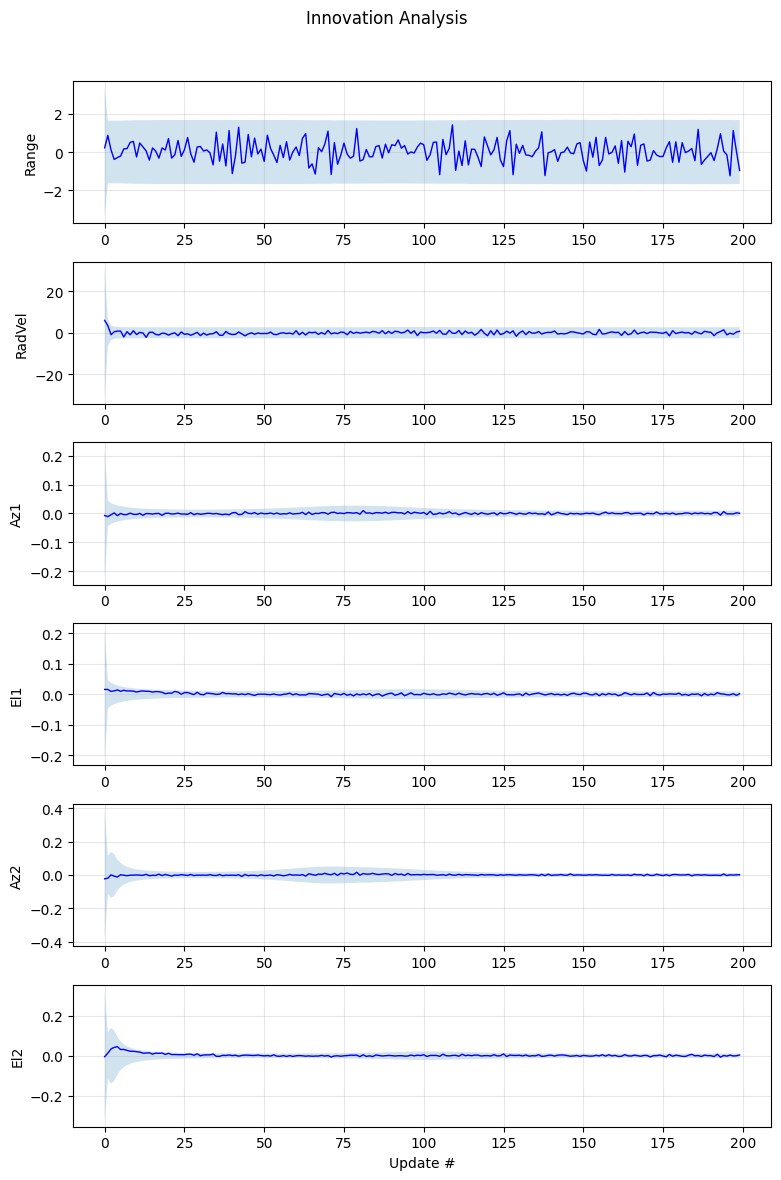

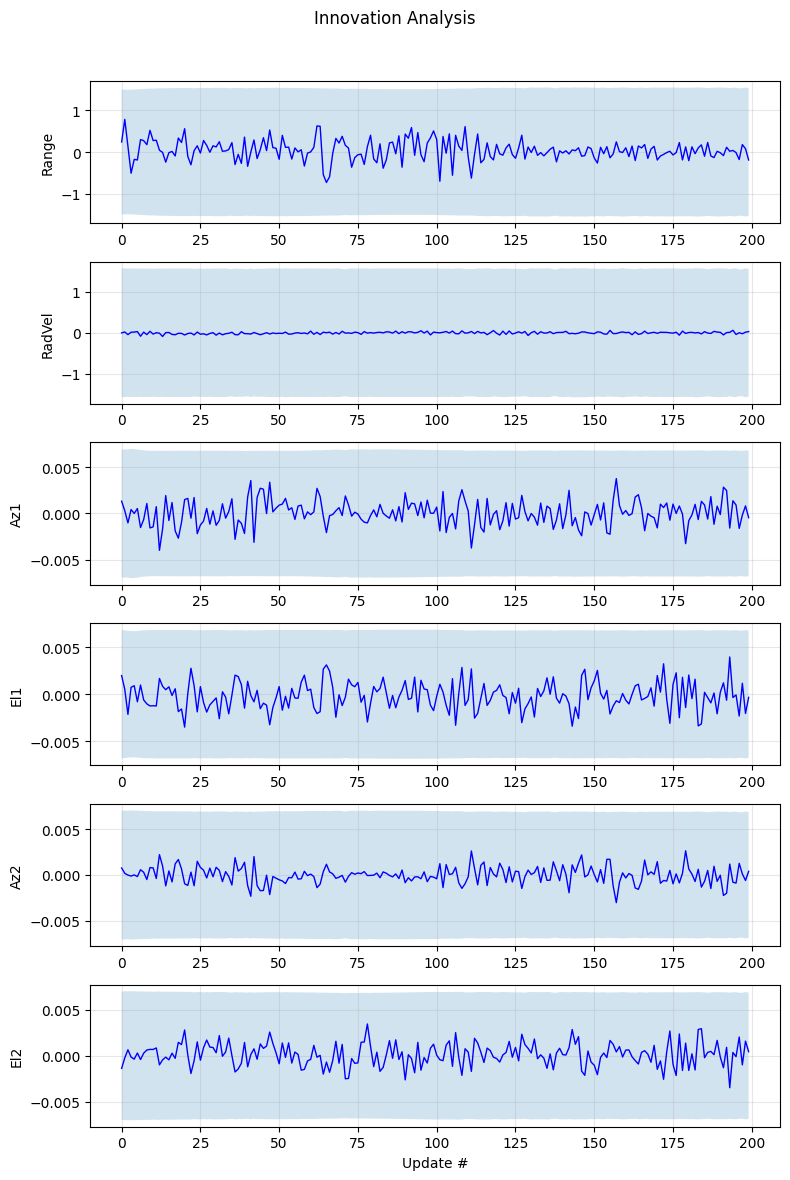

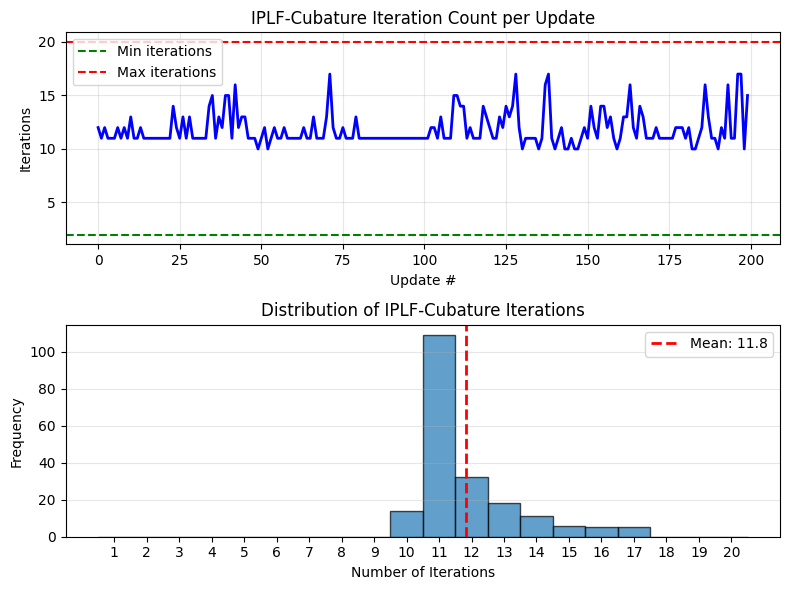

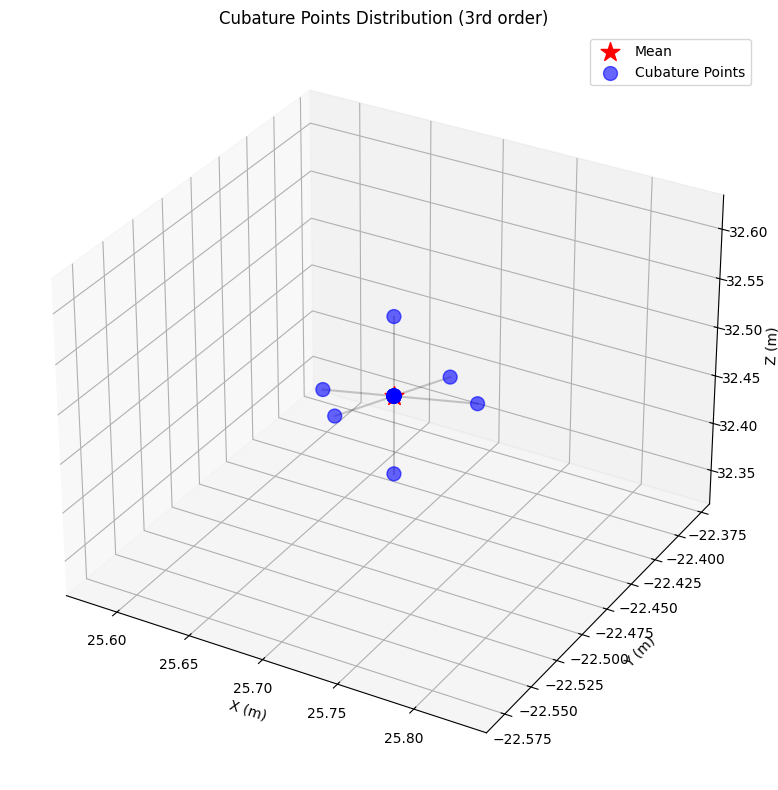

In [28]:
if __name__ == "__main__":
    # 3rd-order run
    main(use_5th_order=False)

Simulated 1001 states, 200 measurements

=== Performance Metrics ===
Filter Type    : IPLF-Cubature (5th order)
Sigma Points   : 163 per update
Position RMSE  : 0.200 m
Velocity RMSE  : 1.741 m/s
Backspin MAE   : 515 RPM
IPLF Iterations: min=2, max=20, threshold=0.01
Avg iterations : 11.8
NIS (predicted): 4.19
NIS (filtered) : 1.56



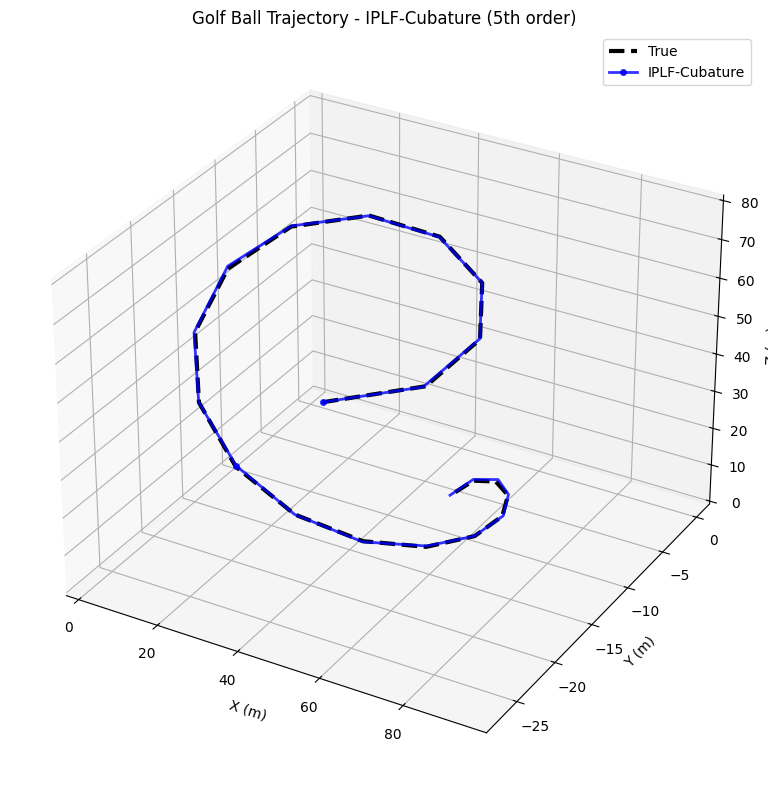

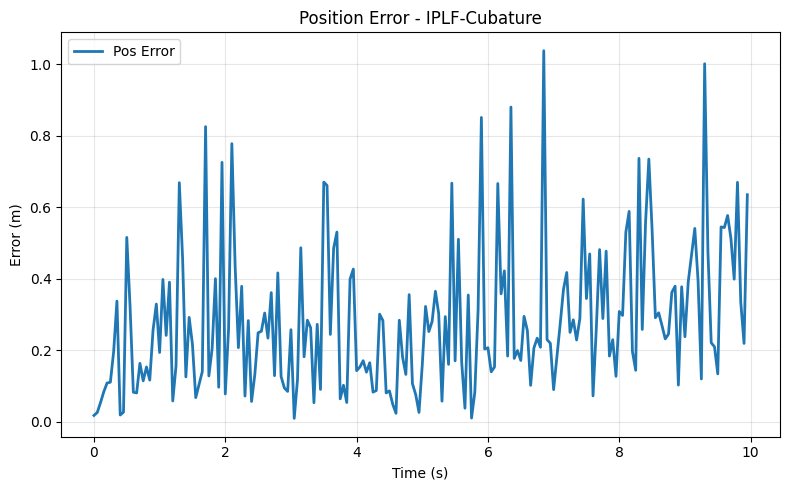

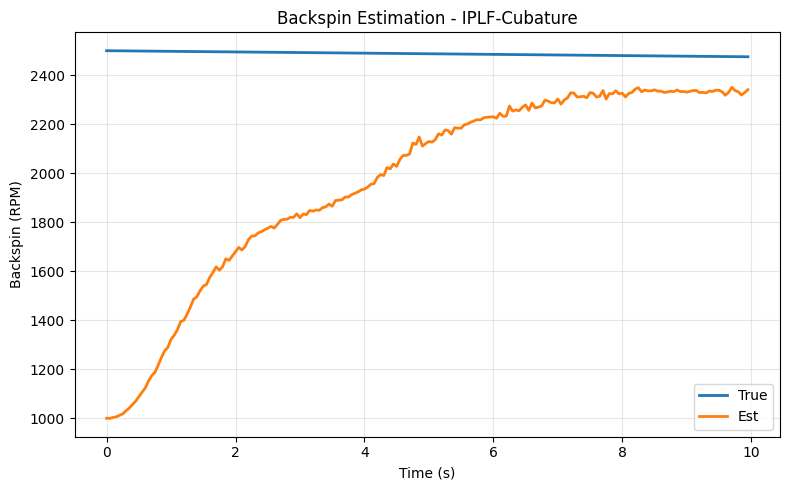

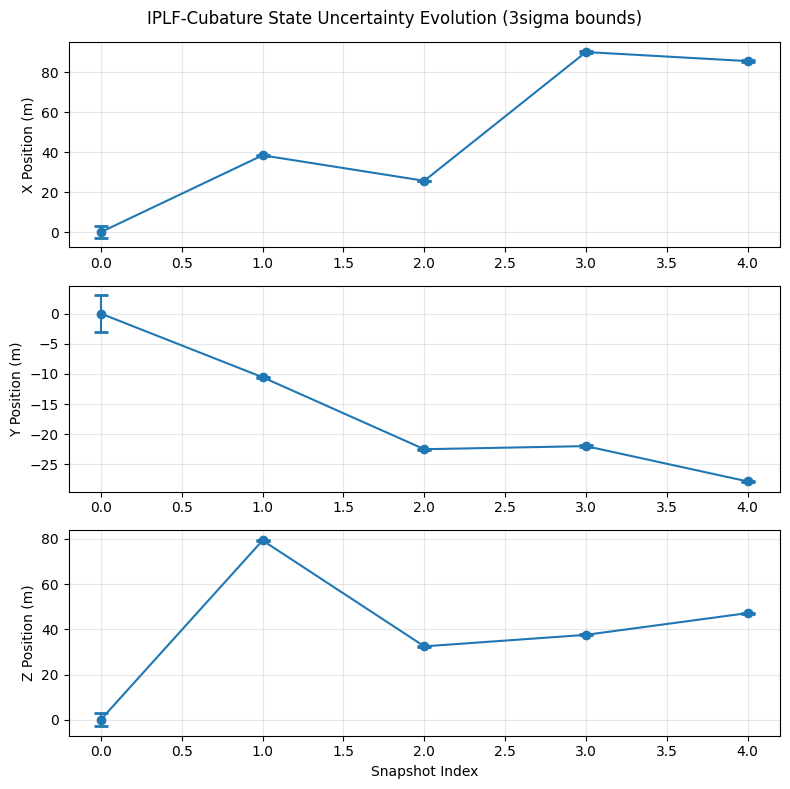

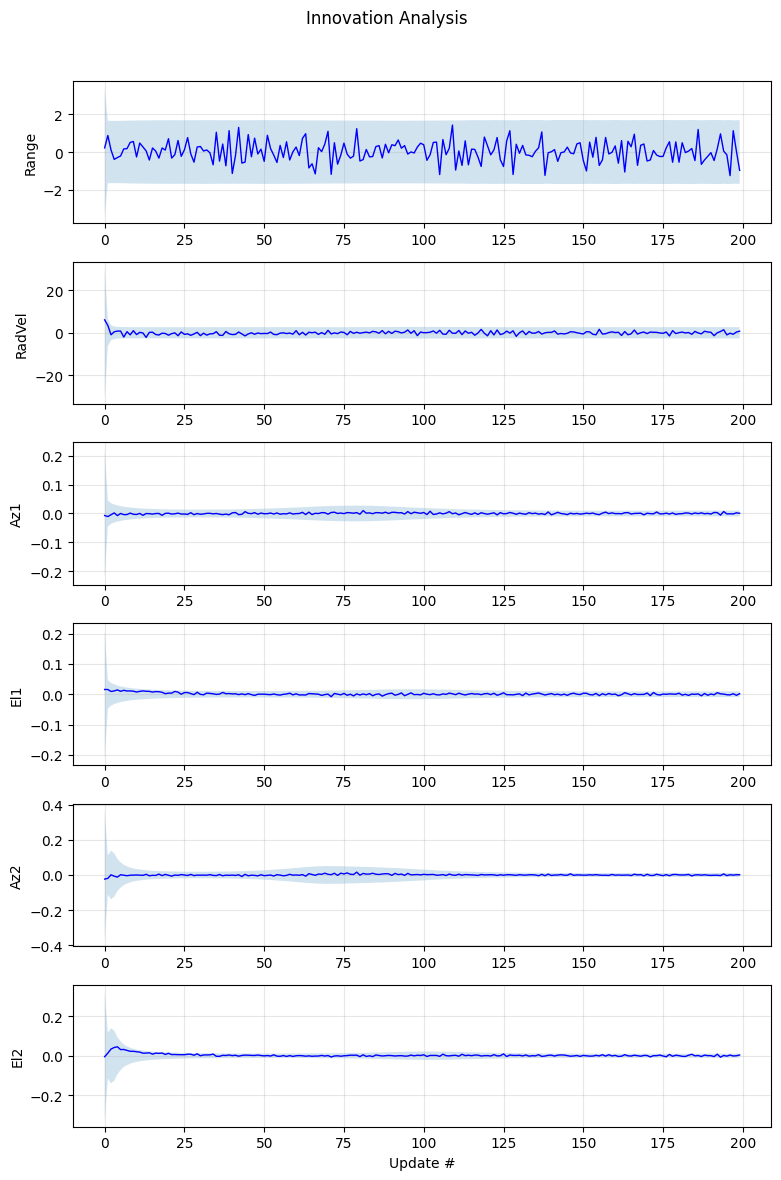

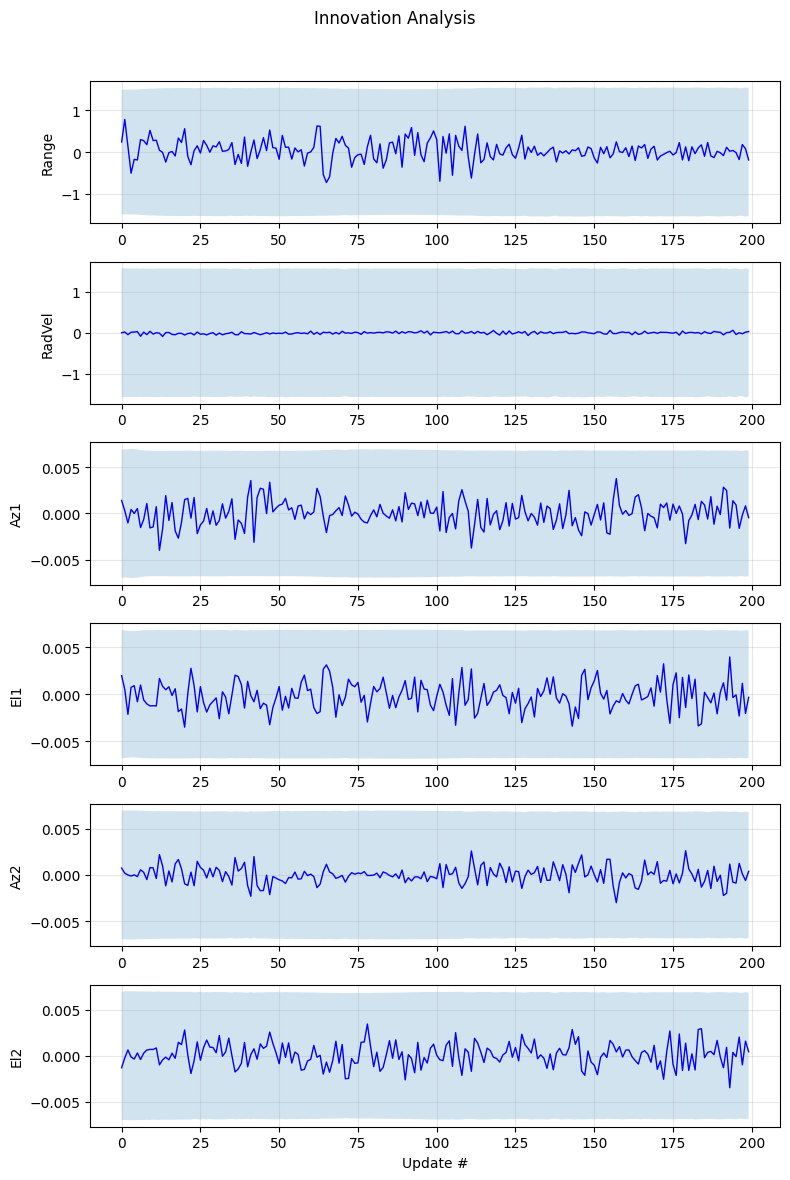

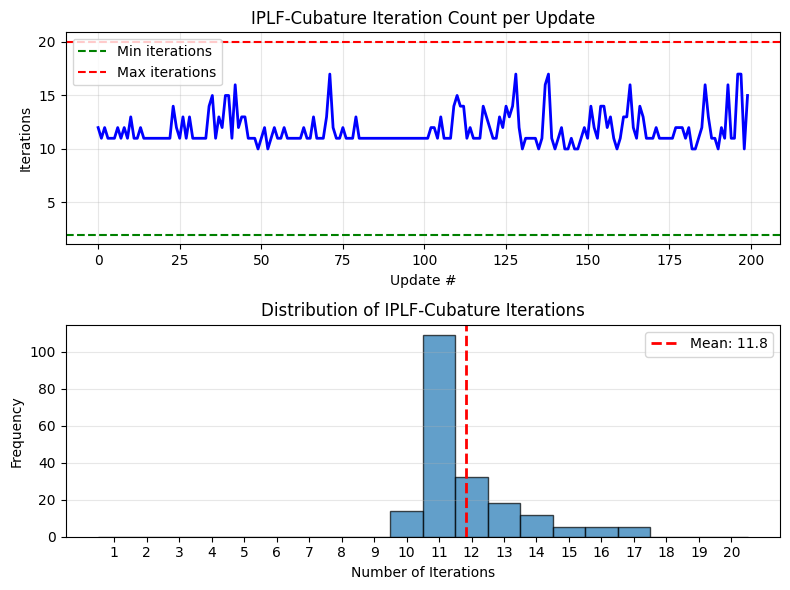

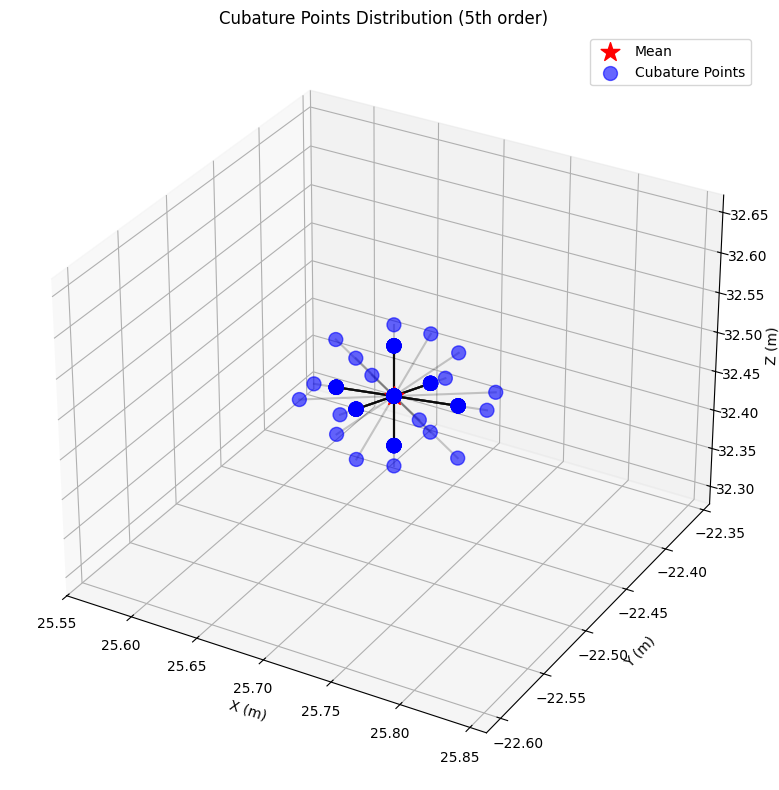

In [29]:
if __name__ == "__main__":
    # 5th-order run
    main(use_5th_order=True)